## Linear Supervised Learning Series

# Part 2: Logistic regression

In the previous post we discussed the fitting of a linear model to a set of input/output points - otherwise known as *linear regression*. In general all sorts of nonlinear phenomena present themselves, and the data they generate - whose input and output share a nonlinear relationship - are poorly modeled using a linear model, thus causing linear regression to perform rather poorly. This naturally leads to the exploration of fitting *nonlinear* functions to data, referred to in general as *nonlinear regression*.

In this post we describe a very particular form of nonlinear regression called *logistic regression* that is designed to deal with a very particular kind of dataset that is commonly dealt with in machine learning/deep learning: *two-class classification data*. This sort of data is distinguished from the sort of data we saw previously by the fact that its output values are constrained to be either one of two fixed values. As we will see, such a constraint naturally leads to the choice of a *logistic sigmoid function* as the ideal nonlinear function to fit to such data, hence the name *logistic regression*. Common examples of two class classification problems include face and general object detection, with classes consisting of with a face or object versus non-facial/object images, textual sentiment analysis where classes consist of written product reviews ascribing a positive or negative opinion, and automatic diagnosis of medical conditions where classes consist of medical data corresponding to patients who either do or do not have a specific malady.  

In [1]:
# imports from custom library
import sys
sys.path.append('../../')
import matplotlib.pyplot as plt
from mlrefined_libraries import superlearn_library as superlearn
import autograd.numpy as np
import pandas as pd
%matplotlib notebook

# this is needed to compensate for %matplotlib notebook's tendancy to blow up images when plotted inline
from matplotlib import rcParams
rcParams['figure.autolayout'] = True

%load_ext autoreload
%autoreload 2

# 1.  Logistic regression

In this Section we set the scene for logistic regression by describing the problem setup and how linear regression - as well as reasonable extensions of it - naturally fail with such data.

## 1.1 The data

Two class classification is a particular instance of *regression* or *surface-fitting*, wherein the output of a dataset of $P$ points $\left\{ \left(\mathbf{x}_{p},y_{p}\right)\right\} _{p=1}^{P}$ is no longer continuous but takes on two fixed numbers.  The actual value of these numbers is in principle arbitrary, but particular value pairs are more helpful than others for derivation purposes (i.e., it is easier to determine a proper nonlinear function to regress on the data for particular output value pairs). We will typically use $y_{p}\in\left\{ -1,\,+1\right\}$ - that is every output takes on either the value $+1$ or $-1$. Often in the context of classification the output values $y_p$ are called *labels*, and all points sharing the same label value are referred to as a *class* of data.  Hence a dataset containing points with label values $y_{p}\in\left\{ -1,\,+1\right\}$ is said to be a dataset consisting of two classes.

The simplest shape such a dataset can take is that of a set of linearly separated adjacent 'steps', as illustrated in the figure below. Here the 'bottom' step is the region of the space containing most of the points that have label value $y_p = -1$.  The 'top step' likewise contains most of the points having label value $y_p = +1$. These steps are largely separated by a point when $N = 1$, a line when $N = 2$, and a hyperplane when $N$ is larger (the term 'hyperplane' is also used more generally to refer to a point or line as well).  

As shown in the figure, because its output takes on a discrete set of values one can view a classification dataset 'from above'.  In this 'separator' perspective we remove the vertical $y$ dimension of the data and visually represent the dataset using its input only, displaying the output values of each point by coloring its input one of two unique colors (we choose blue for points with label $y_p = -1$, and red for those having label $y_p = +1$). This separator view allows us to more easily identify the linear boundary that (mostly) separates the two classes.

<figure>
  <img src= '../../mlrefined_images/superlearn_images/Fig_4_10_new.png' width="80%" height="60%" alt=""/>
  <figcaption>   
<strong>Figure 1:</strong> <em> Classification from a regression/surface-fitting perspective for single-input (left panels) and two-input (right panels) toy datasets. This surface-fitting view is equivalent to the 'separator' perspective where we look at each respective dataset 'from above'.  In this perspective we can more easily identify the separating hyperplane, i.e., where the step function (shown here in yellow) transitions from its bottom to top step.  In the separator view the vertical axis (the actual $y$ value) is removed, with all points being represented by their input values only.  The label of each point is then represented by color: the points in blue denote label value $+1$ while those in red have label $-1$. </em>  </figcaption> 
</figure>

This is the simplest sort of dataset with binary output we could aim to perform regression on, as in general the boundary between the two classes of data could certainly be nonlinear. We will deal with this more general potentiality later on - when discussing neural networks, trees, and kernel-based methods - but first let us deal with the current scenario.  How can we perform regression on a dataset like the ones described in the figure above?

## 1.2  Trying to fit a discontinuous step function

How can we fit a regression to data that is largely distributed on two adjacent steps separated by a hyperplane? Lets look at a simple instance of such a dataset when $N = 1$ to build our intuition about what must be done in general.

Intuitively it is obvious that simply fitting a line of the form $y = w_0 + w_1x_{\,}$ to such a dataset will result in an extremely subpar results - the line by itself is simply too inflexible to account for the nonlinearity present in the data.  A dataset that is roughly distributed on two steps needs to be fit with a function that matches this general shape. In other words such data needs to be fit with a *step function*.

Since the boundary between the two classes is (assumed to be) linear and the labels take on values that are either $+1$ or $-1$, ideally we would like to fit a *discontinuous step function with a linear boundary* to such a dataset.  What does such a function look like?  When $N = 1$ it is simply a line $y = w_0 + x_{\,}w_1$ composed with the $\text{sign}(\cdot)$ function

\begin{equation}
\text{sign}\left(w_0 + x_{\,}w_1 \right)
\end{equation}

Remember that the $\text{sign}(\cdot)$ function is defined as $\text{sign}(\alpha) = 
\begin{cases}
+1 \,\,\,\,\,\text{if} \,\, \alpha > 0 \\
-1 \,\,\,\,\,\text{if} \,\, \alpha < 0 \\
\end{cases}$.  Note here that what happens with $\text{sign}(0)$ is - for our purposes - arbitrary (i.e., it can be set to any fixed value or left undefined as we have done).

How do we tune the parameters of the line?  We could try to take the lazy way out and *first* fit the line to the classification dataset via linear regression, then compose the line with the sign function to get a step function fit.  However this does not work well in general - as we will see even in the simple instance below.  Instead we need to tune the parameters $w_0$ and $w_1$ *after* composing the line with the sign function, or in other words we need to tune the parameters of $\text{sign}\left(w_0 + x_{\,}w_1 \right)$.

#### <span style="color:#a50e3e;">Example 1: </span> Fitting a line first and taking the sign afterward fails to represent a two-class dataset well

In the Python cell below we load in a simple two-class dataset (top panel), fit a line to this dataset via linear regression, and then compose the fitted line with the sign function to produce a step function fit. Both the linear fit (in green) as well as its composition with the sign function (in dashed red) are shown along with the data in the bottom panel.  Of course the line itself provides a terrible representation of the nonlinear dataset. But its evaluation through sign is also quite poor for such a simple dataset, failing to properly identify two points on the top step. In the parlance of classification these types of points are referred to as *misclassified points*.

In [4]:
# load in dataset
data = np.loadtxt('../../mlrefined_datasets/superlearn_datasets/2d_classification_data_v1.csv')

<IPython.core.display.Javascript object>


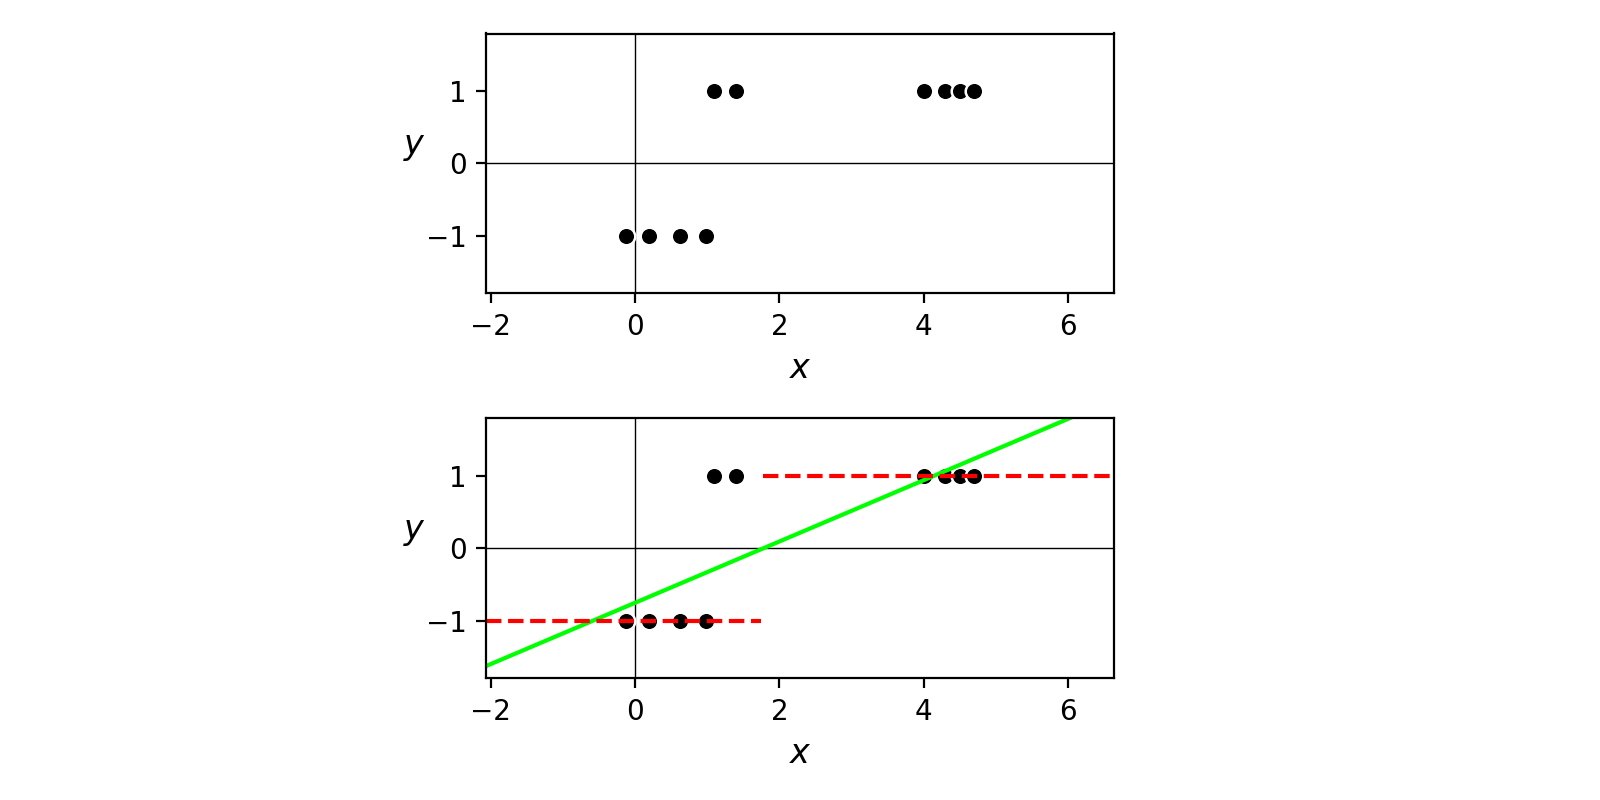

In [5]:
# create instance of linear regression demo, used below and in the next examples
demo1 = superlearn.logistic_regression_simple_demos.visualizer(data)
demo1.run_algo(algo = 'newtons_method',w_init = [-1,-1], max_its = 1)

# plot dataset
demo1.naive_fitting_demo()

----

How do we tune these parameters properly? As with linear regression, here we can try to setup a proper Least Squares function that - when minimized - recovers our ideal weights. We can do this by simply reflecting on the sort of ideal relationship we want to find between the input and output of our dataset. 

Take a single point $\left(x_p,\,y_p \right)$. Notice in the example above - and this is true more generally speaking - that ideally for a good fit we would like our weights to be such if this point has a label $+1$ it lies in the positive region of the space where $w_0 + xw_1 > 0$ so that $\text{sign}\left(w_0 + w_1x_p\right) = +1$ matches its label value.  Likewise if this point has label $-1$ we would like it to lie in the negative region where $w_0 + xw_1 < 0$ so that $\text{sign}\left(w_0 + x_pw_1\right) = -1$ matches its label value. So in short what we would ideally like for this point is that its evaluation matches its label value, i.e., that

\begin{equation}
\text{sign}\left(w_0 + x_pw_1 \right) = y_p 
\end{equation}

And of course we would like this to hold for every point.  To find weights that satisfy this set of $P$ equalities as best as possible we could - as we did previously with linear regression - square the difference between both sides of each and sum them up, giving the Least Squares function

\begin{equation}
g(w_0,w_1) = \sum_{p=1}^P \left(\text{sign}\left(w_0 + x_pw_1 \right) - y_p \right)^2
\end{equation}

which we can try to minimize in order to recover weights that satisfy our desired equalities. If we can find a set of weights such that $g(w_0,w_1) = 0$ then all $P$ equalities above hold true, otherwise some of them do not. Notice: the evaluation of this Least Squares cost for any given $w_0$ and $w_1$ is (four times) the number of *misclassified points* for that particular choice of weights, and as a result is always integer valued. Because it counts the number of misclassifications this cost function is often referred to as the *counting cost* for two-class classification.

Unfortunately because the counting cost takes on only integer values it is impossible to minimize with our gradient-based techniques, as at every point the function is completely flat, i.e., it has exactly zero gradient. Because of this neither gradient descent nor Newton's method can take a single step 'downhill' regardless of where they are initialized. This problem is inherited from our use of the sign function, itself a discontinuous step.

#### <span style="color:#a50e3e;">Example 2: </span> Visualizing the counting cost on a simple dataset

In the next Python cell we plot the counting cost (left panel) for the dataset displayed in Example 1, over a wide range of values for $w_0$ and $w_1$.  The counting cost surface consists of discrete steps at many different levels, each one completely flat.  Because of this no local method can be used to minimize the counting cost.

In the middle and right panels we plot the surfaces of two related cost functions on the same dataset.  We introduce the cost function shown in the middle panel in the next subection, and the cost in the right panel in the one that follows.  We can indeed minimize either of these using a local method to recover ideal weights.

<IPython.core.display.Javascript object>


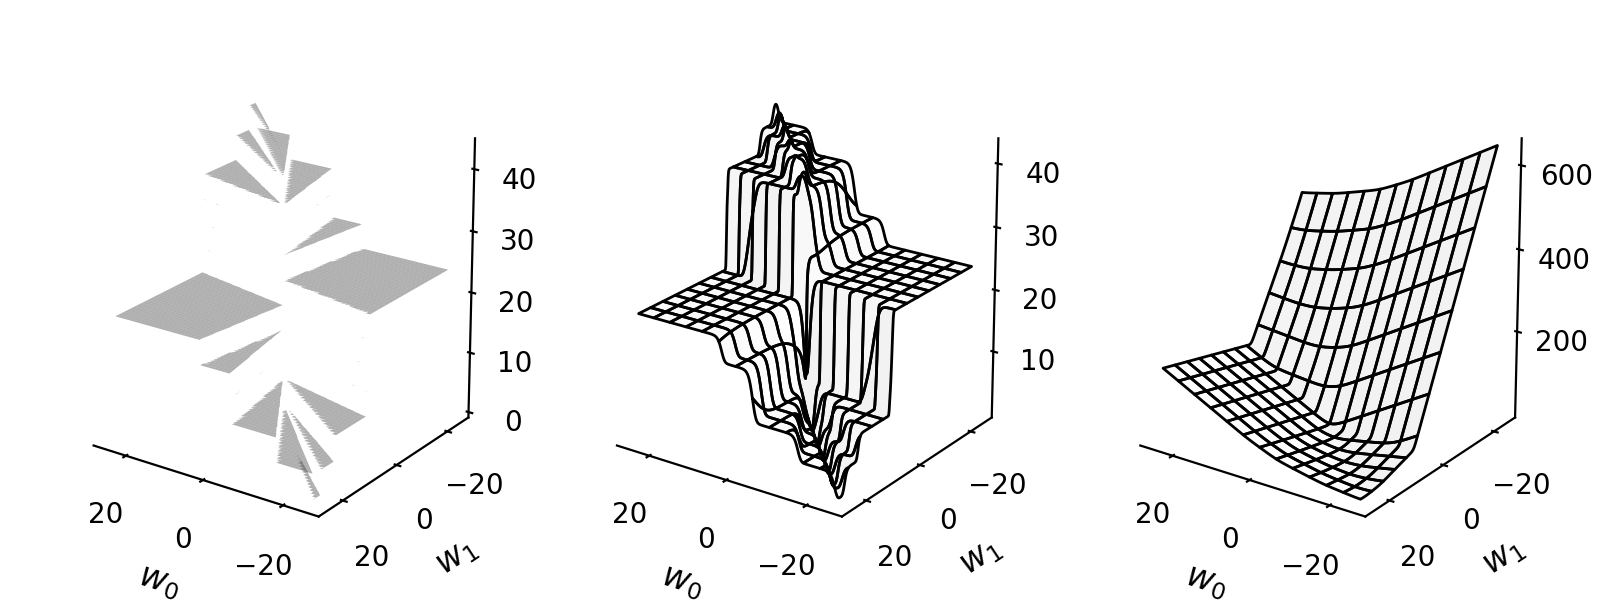

In [5]:
# create an instance of the visualizer and plot
demo2 = superlearn.cost_viewer.Visualizer(data)
demo2.plot_costs(viewmax = 25,view = [20,125])

## 1.2  Introducing the hyperbolic tangent function and a logistic Least Squares

As mentioned above, we cannot directly minimize the counting cost due to our use of the sign function. In other words, we cannot directly fit a *discontinuous* step function to our data. In order to go further we need to replace the sign, ideally with a *continuous* function that matches it very closely everywhere. Thankfully such a function is readily available: the hyperbolic tangent function, $\text{tanh}(\cdot)$, first introduced along with its close relative - the logistic sigmoid function - in our post on elementary functions and operations in the basics of mathematical functions series. In the figure below we plot the tanh function (left panel), as well as several internally weighted versions of it (right panel). As we can see in the figure, for the correct setting of internal weights the hyperbolic tangent function can be made to look arbitrarily similar to the sign function.

<figure>
  <img src= '../../mlrefined_images/superlearn_images/Fig_4_11_new.png' width="80%" height="80%" alt=""/>
  <figcaption>   
<strong>Figure 2:</strong> <em> (left panel) Plot of the hyperbolic tangent function $\text{tanh}(x)$. (right panel) By increasing the weight $w$ in $\text{tanh}(wx)$ from $w=1$ (shown in red) to $w=2$ (shown in green) and finally to $w=10$ (shown in blue), the internally weighted version of the tanh function becomes an increasingly
good approximator of the sign function. </em>  </figcaption> 
</figure>

Swapping out the sign function with tanh in equation (2) we aim to satisfy as many of the $P$ equations

\begin{equation}
\text{tanh}\left(w_0 + x_pw_1 \right) = y_p 
\end{equation}

as possible. Using the same logic used previously to achieve this we can form the following Least Squares cost for *logistic regression*

\begin{equation}
g(\mathbf{w}) = \sum_{p=1}^P \left(\text{tanh}\left(w_0 + x_pw_1 \right) - y_p \right)^2
\end{equation}

This cost function can indeed be minimized using local methods, but it is non-convex and contains large flat regions which limits our choice of algorithms to *normalized gradient descent*.  In Example 2 we plotted the surface of this Least Squares cost in the middle panel of the printout using the toy dataset from Example 1.

#### <span style="color:#a50e3e;">Example 3: </span> Using normalized gradient descent to perform logistic regression using the Least Squares cost

In this example we show how normalized gradient descent can be used to minimize the logistic Least Squares cost function described above. First, we write out this cost function in Python in the next cell.  This translation is fairly straightforward.

In [6]:
# define the input and output of our dataset
x = data[:,0]
x.shape = (len(x),1)
y = data[:,1]
y.shape = (len(y),1)

# tanh non-convex logistic least squares cost function
def tanh_least_squares(w):
    cost = 0
    for p in range(0,len(y)):
        x_p = x[p,:]
        y_p = y[p]
        cost +=(np.tanh(w[0] + w[1]*x_p) - y_p)**2
    return cost

With this cost function defined in Python we can now run our demonstration of normalized gradient descent below. We will use the automatic differentiator [autograd](https://github.com/HIPS/autograd) here (as well as in future examples in this post) to compute derivatives of the cost, along with the generic Python code for gradient descent provided in the respective post in our *mathematical optimization* series. We initialize at $w_0 = 3$ and $w_1 = 3$, set $\alpha = 1$, and run for 25 steps.  

In [7]:
# declare an instance of our current our optimizers
opt = superlearn.optimimzers.MyOptimizers()

# run desired algo with initial point, max number of iterations, etc.,
w_hist = opt.gradient_descent(g = tanh_least_squares,w = [3,3],version = 'normalized',max_its = 25, alpha = 1)

We now animate each step of the run - along with its corresponding fit to the data. In the left panel both the data and the fit at each step (colored green to red as the run continues) are shown, while in the right panel the contour of the cost function is shown with each step marked (again colored green to red as the run continues).  Moving the slider from left to right animates the run from start to finish.


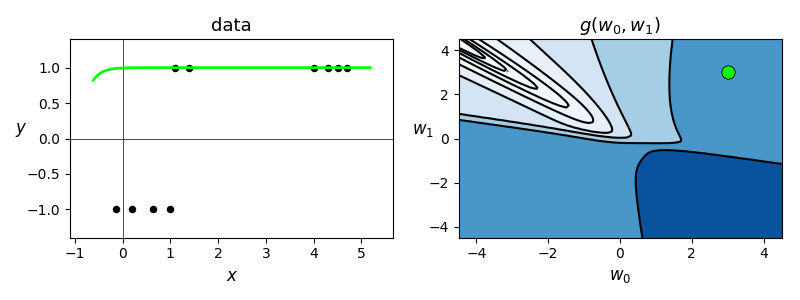
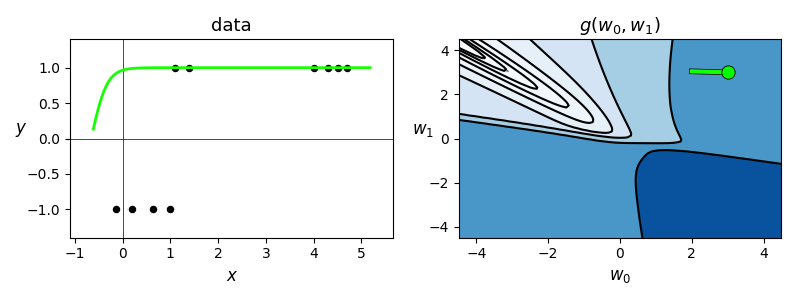
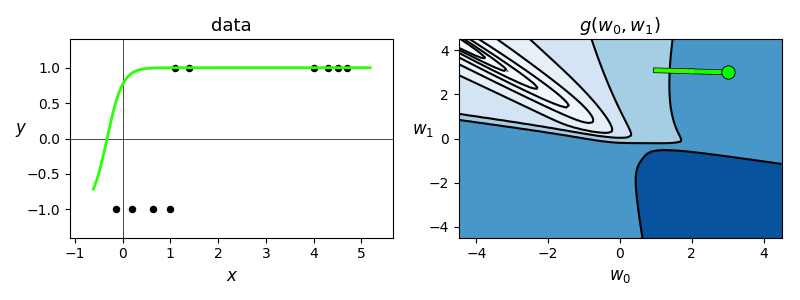
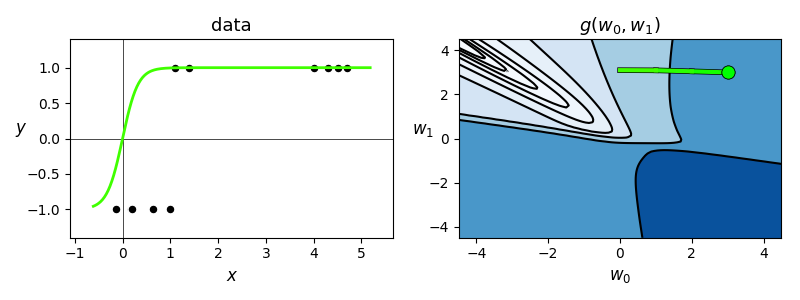
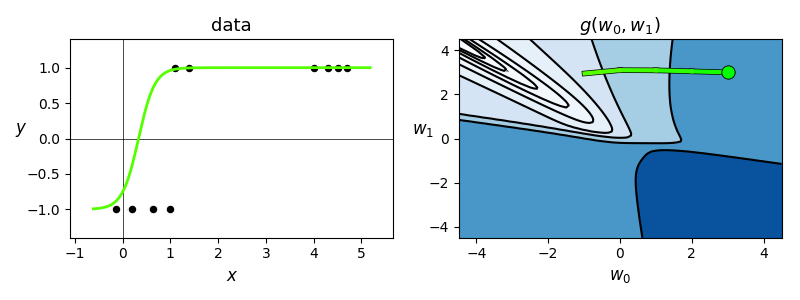
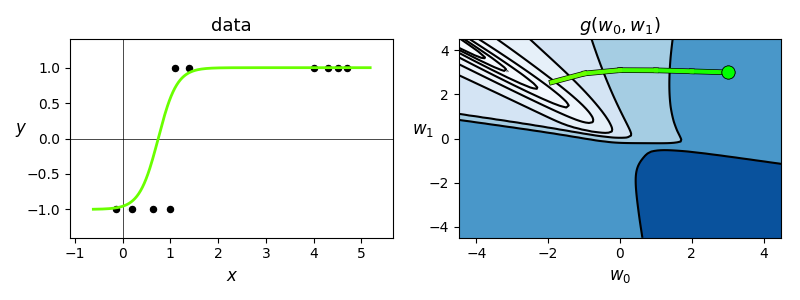
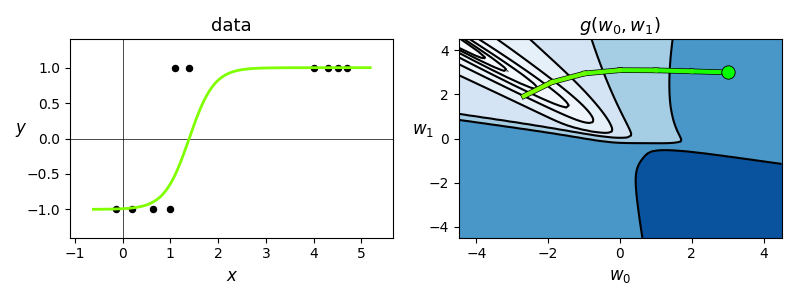
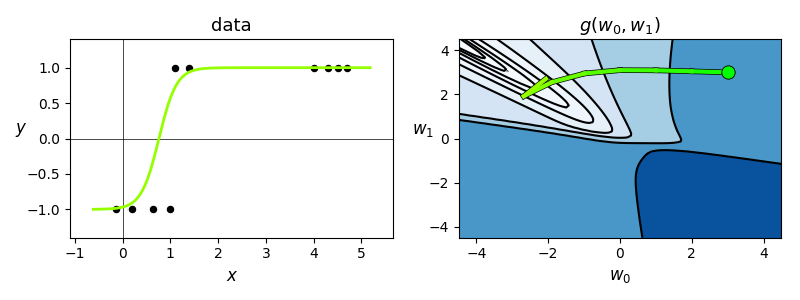
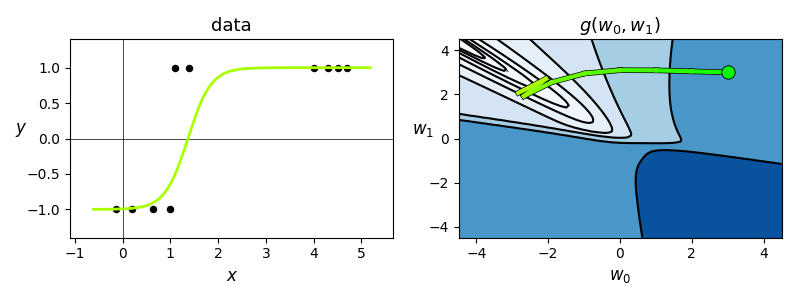
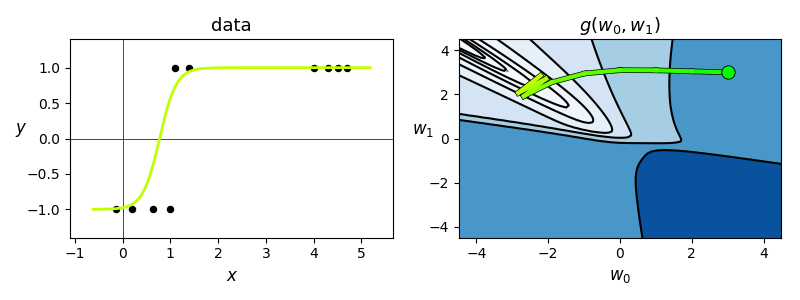
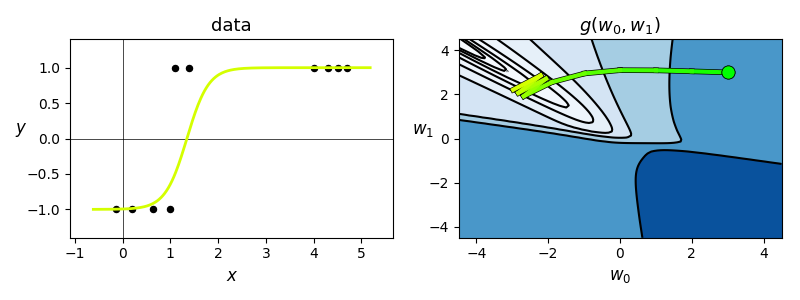
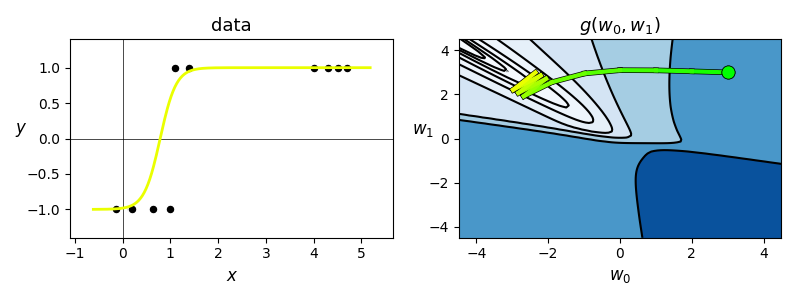
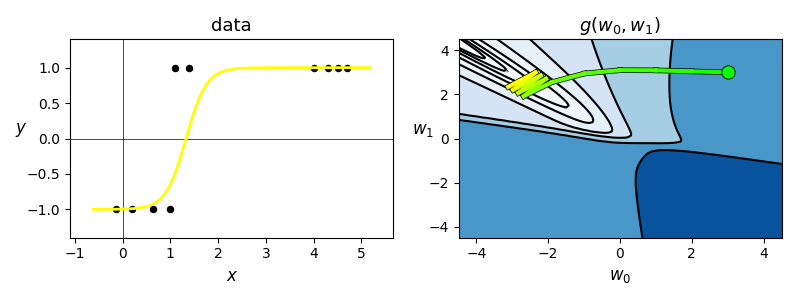
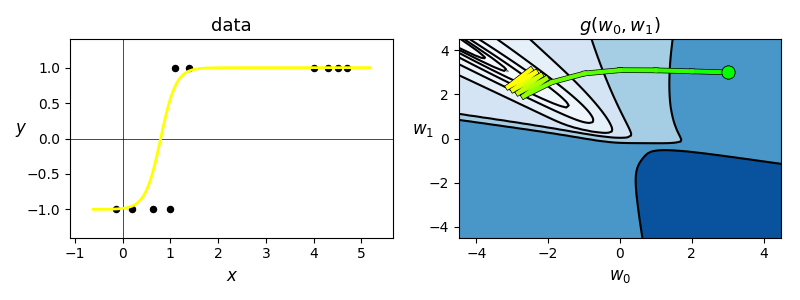
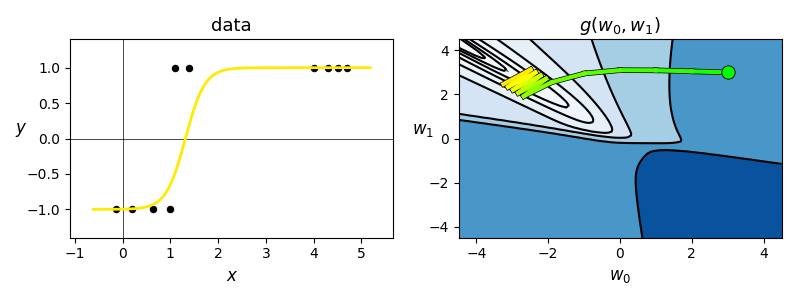
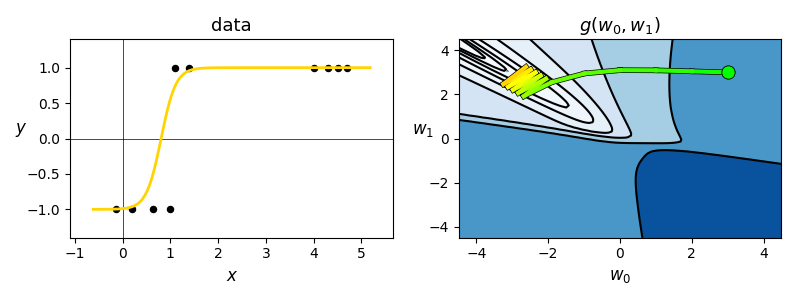
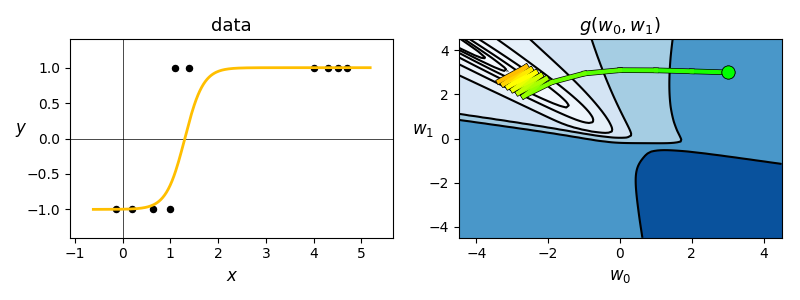
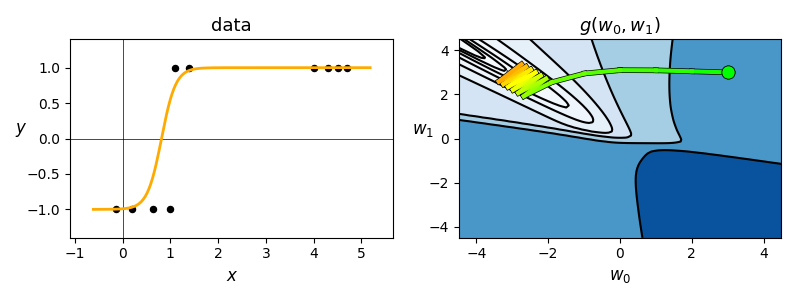
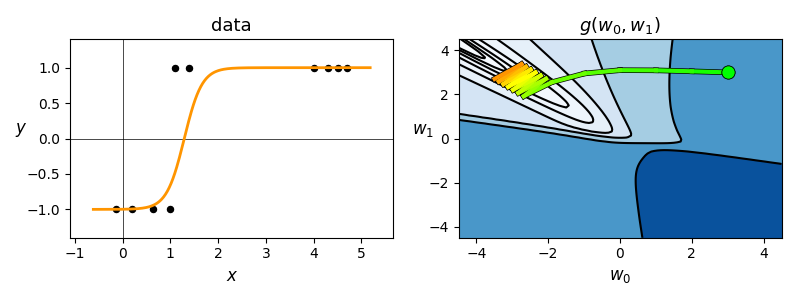
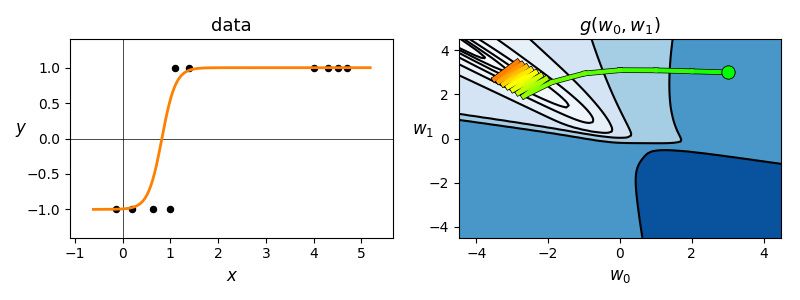
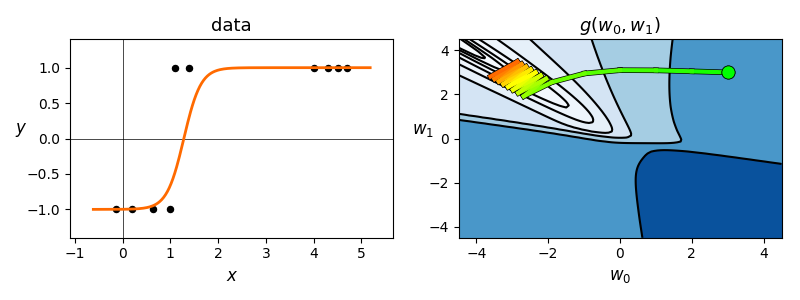
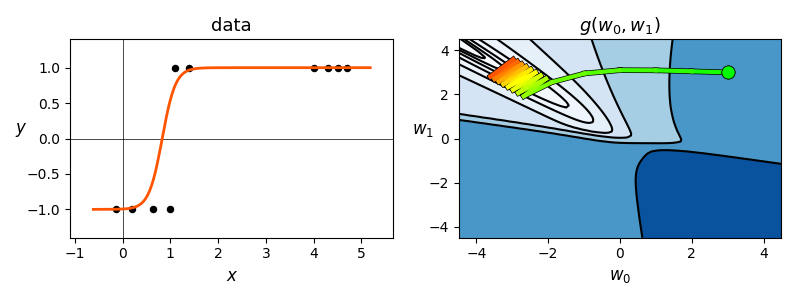
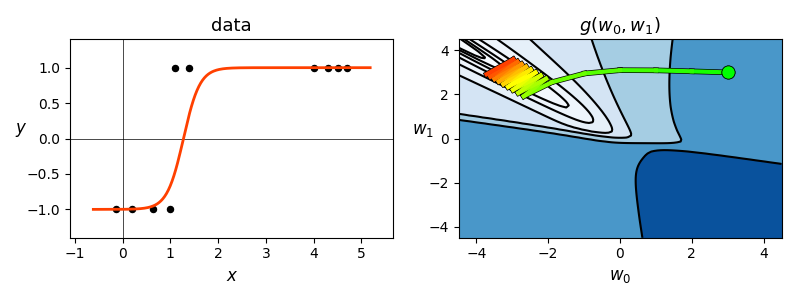
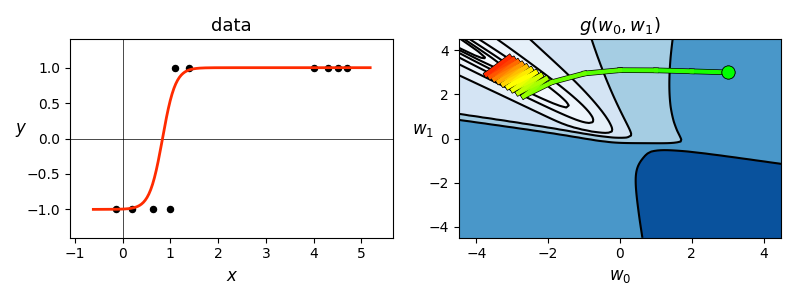
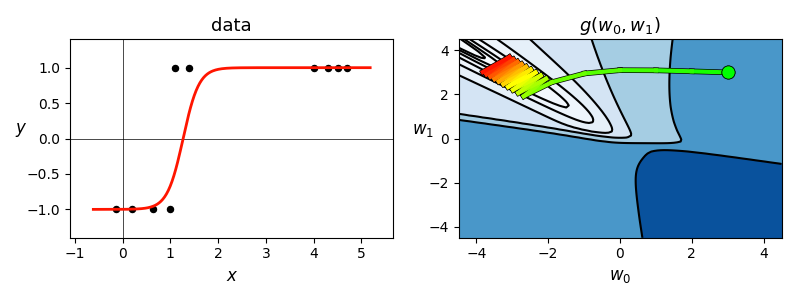
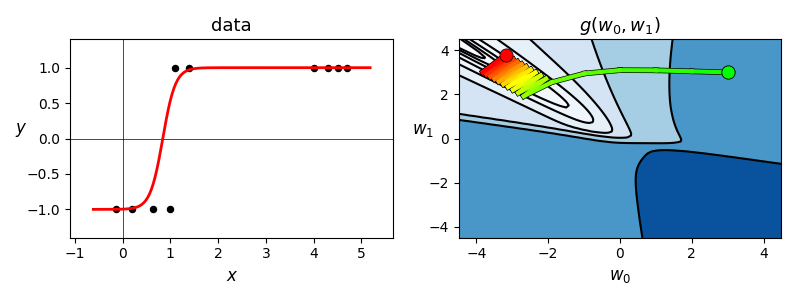

In [8]:
# create instance of logisic regression demo and load in data, cost function, and descent history
demo3 = superlearn.classification_2d_demos.Visualizer(data,tanh_least_squares)

# animate descent process
demo3.animate_run(w_hist,num_contours = 25,viewmax = 4.5)

Near the end of the run notice how the algorithm zig-zags back and forth along a long narrow valley while moving towards the minimum of the function (this long narrow valley towards the minimum can also be seen in the surface plot of the cost function - shown in the middle panel of Example 2). This behavior is common for gradient descent when running down long narrow valleys, in particular when using the normalized form when the length of each step is kept the same by fixing the steplength parameter $\alpha$.

Nonetheless while we did not run it until convergence here we can indeed reach the minimum of the cost function using gradient descent if we run long enough (possibly adjusting the steplength parameter $\alpha$ along the way). We show this in the next Python cells where we run the same algorithm from the initial point $w_0 = 20$ and $w_1 = -20$, even farther away from the global minimum for 900 steps. However the zig-zagging effect seen here will mean that we need to take a great many steps to reach a minimum. 

In [9]:
# run desired algo with initial point, max number of iterations, etc.,
w_hist = opt.gradient_descent(g = tanh_least_squares,w = [20,-20],version = 'normalized',max_its = 900, alpha = 1)

With gradient descent complete we can now produce a static figure illustrating its path towards the minimum.

<IPython.core.display.Javascript object>


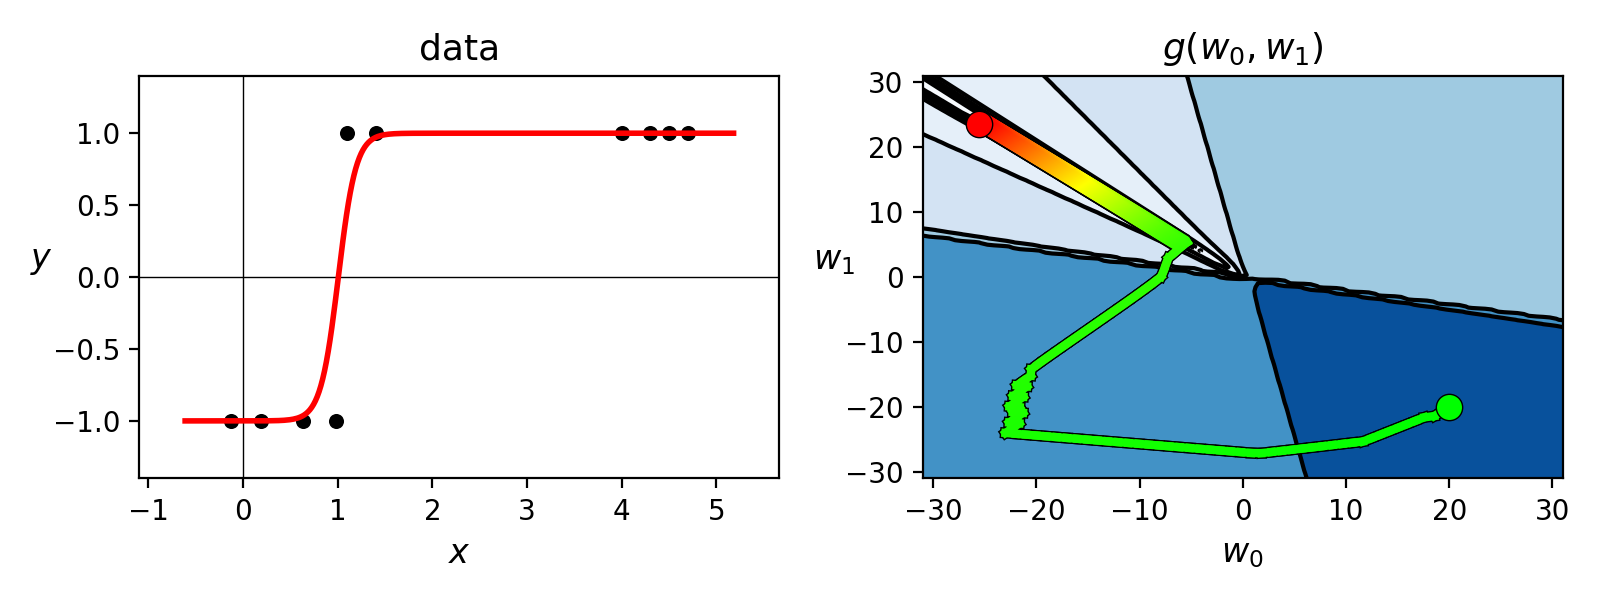

In [10]:
# create a static figure illustrating gradient descent steps 
demo3.static_fig(w_hist,num_contours = 25,viewmax = 31)

---

The optimization phenomenon we saw in the previous example - that of zig-zagging and long narrow valleys leading to global minima - are common occurrence with *neural networks* cost functions (our logistic Least Squares cost function being a simple example of one). As we will see later there are a number of practical 'tricks' we can use to try to ameliorate zig-zagging behavior in general (e.g., adding a *momentum* term as well as *regularization*). 

For the relatively simple case of logistic regression we can more easily ameliorate this problem by going back to our desired equalities shown in equation (4) and re-formulating the logistic regression problem from scratch.  This leads to a different (and, as we will see, always convex) cost function for logistic regression that is more commonly used in practice.

## 1.3  The convex logistic regression 

There is more than one way to form a cost function whose minimum forces as many of the $P$ equalities in equation (4) to hold as possible. For instance, because tanh is an *odd* function - that is $\text{tanh}(s) = -\text{tanh}(-s)$ for all $s$ - and because $y_{p}\in\left\{ -1,\,+1\right\}$, equation (4) can be written, multiplying both sides by $y_p$, as 

\begin{equation}
\text{tanh}\left(y_p\left(w_0 + xw_1\right)\right) = 1
\end{equation}

Here the right hand side of the equality is one since we always have that $y_p^2 = 1$.  Now we can use the exponential definition of tanh

\begin{equation}
\text{tanh}\left(s\right) = \frac{2}{1 + e^{-s}}-1
\end{equation}

to rewrite each desired equality equivalently as 

\begin{equation}
1 + e^{-y_p\left(w_0 + xw_1\right)} = 1
\end{equation}

From here we could either subtract one off of both sides to give equivalently

\begin{equation}
e^{-y_p\left(w_0 + xw_1\right)} = 0
\end{equation}

or take the log of both sides to give

\begin{equation}
\text{log}\left(1 + e^{-y_p\left(w_0 + xw_1\right)}\right) = 0
\end{equation}

Both options provide an equivalent way of expressing the desired set of $P$ equalities implied by equation (4), both are nonnegative regardless of $p$, and both can be used to form convex cost functions for logistic regression (the former is often used in the context of *boosting*).  For example, summing over all $P$ of the latter expressions gives the commonly used *softmax* (also called the *log-loss*) cost function for logistic regression 

\begin{equation}
g(\mathbf{w}) = \sum_{p=1}^P\text{log}\left(1 + e^{-y_p\left(w_0 + x_pw_1\right)}\right)
\end{equation}

The softmax cost is *always convex* regardless of the dataset used - we will see this empirically in the examples below and a mathematical proof is provided in the appendix of this post that verifies this claim more generally (one can also compute a conservative but provably convergent steplength parameter $\alpha$ for the softmax cost based on its Lipschitz constant, which is also described in the appendix). We displayed a particular instance of the cost surface in the right panel of Example 2 for the dataset first shown in Example 1. Looking back at this surface plot we can see that it is indeed convex.

Since the softmax cost function is convex unnormalized version of gradient descent is more convenient to use here (as is the case whenever a function is convex, as was detailed in the post on gradient descent in our series on *mathematical optimization*).  This can make management of the steplength parameter $\alpha$ a simpler ordeal in practice since the length of each step is also controlled by the magnitude of the gradient.  Convexity also allows us to immediately apply Newton's method to logistic regression,  which can provide rapid convergence to a global minima.  Furthermore, for a convex function like this both local methods can be guaranteed mathematically to - when implemented correctly - converge to a global minimum.

For these reasons - as well as for the fact that a probabilistic approach for deriving logistic regression leads to a cost function equivalent to the softmax cost above as we will see later in this post - the softmax cost is used more often in practice for logistic regression than is the logistic Least Squares cost for linear classification.

> The softmax cost is more widely used in practice for logistic regression than the logistic Least Squares cost. Being always convex we can use Newton's method to minimize the softmax cost, and we have the added confidence of knowing that local methods (gradient descent and Newton's method) are assured to converge to its global minima.

Note however that while we see less zig-zagging behavior when applying (unnormalized) gradient descent to the softmax cost, convergence of gradient descent can still be slow due to the scaling of the length of each step by the magnitude of the gradient (which vanishes as we approach a global minimum).

#### <span style="color:#a50e3e;">Example 4: </span> Using unnormalized gradient descent to perform logistic regression using the softmax cost

In this example we repeat the experiments of Example 3 using the softmax cost and unnormalized gradient descent. First, we write out this cost function in Python in the next cell. Once again the translation is fairly straightforward.

In [8]:
# define the input and output of our dataset
x = data[:,0]
x.shape = (len(x),1)
y = data[:,1]
y.shape = (len(y),1)

# the convex softmax cost function
def softmax(w):
    cost = 0
    for p in range(0,len(y)):
        x_p = x[p,:]
        y_p = y[p]
        cost += np.log(1 + np.exp(-y_p*(w[0] + w[1]*x_p)))
    return cost

With our cost function defined in Python we can now run our demonstration. We initialize at the point $w_0 = 3$ and $w_1 =3$, set $\alpha = 1$, and run for 25 steps.  

In [12]:
# declare an instance of our current our optimizers
opt = superlearn.optimimzers.MyOptimizers()

# run desired algo with initial point, max number of iterations, etc.,
w_hist = opt.gradient_descent(g = softmax,w = [3,3],version = 'unnormalized',max_its = 25, alpha = 1)

Each step of the run is now animated - along with its corresponding fit to the data.  In the left panel both the data and the fit at each step (colored green to red as the run continues) are shown, while in the right panel the contour of the cost function is shown with each step marked (again colored green to red as the run continues).  Moving the slider from left to right animates the run from start to finish. Note how we still have some zig-zagging behavior here, but since we can safely use unnormalized gradient descent, its oscillations rapidly decrease in magnitude since the length of each step is directly controlled by the magnitude of the gradient.


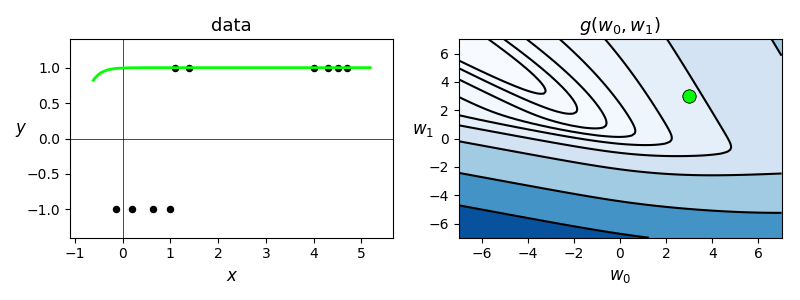
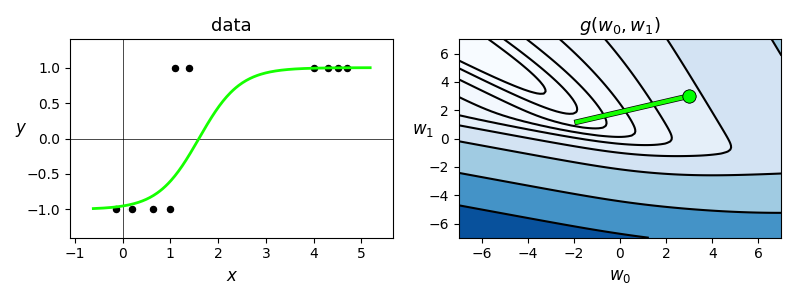
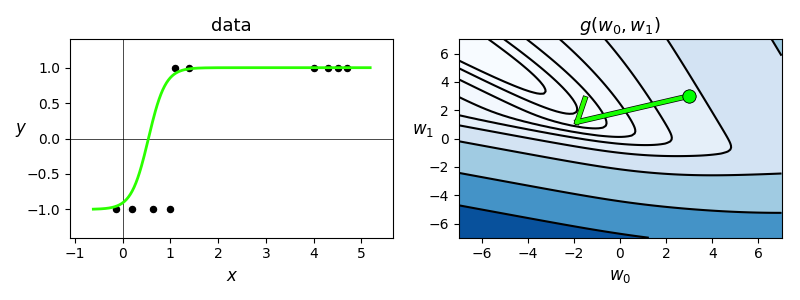
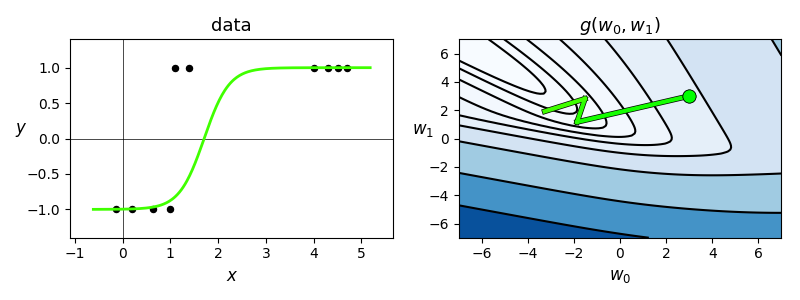
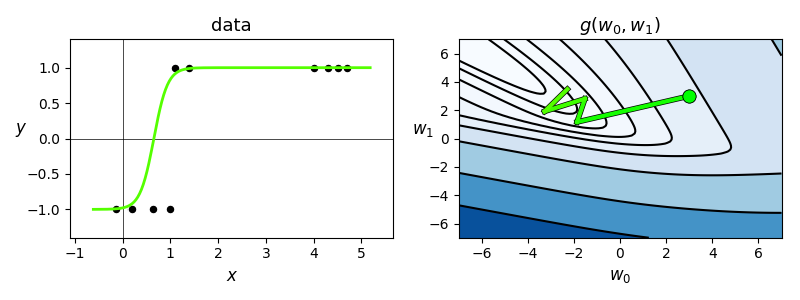
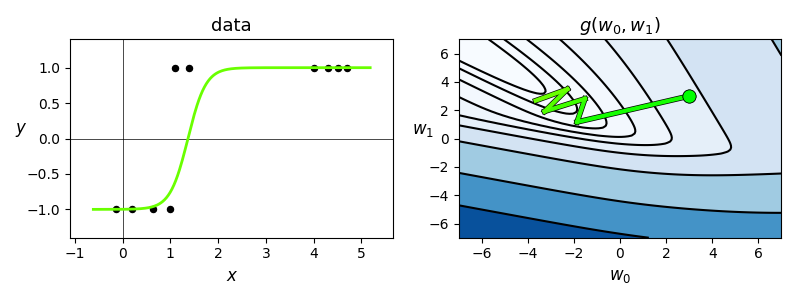
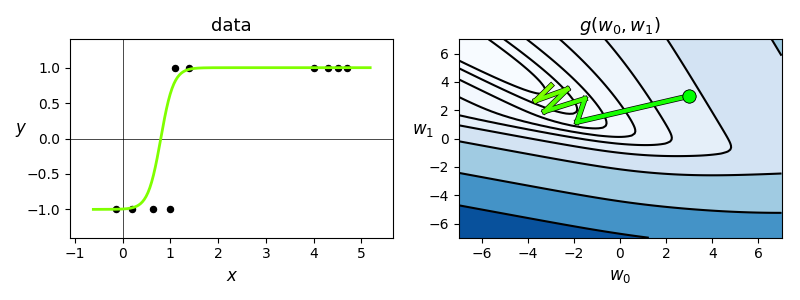
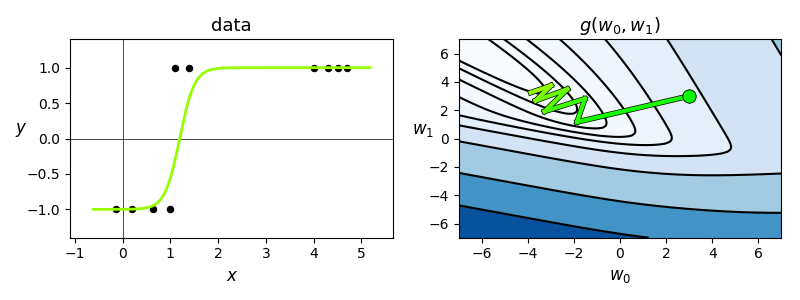
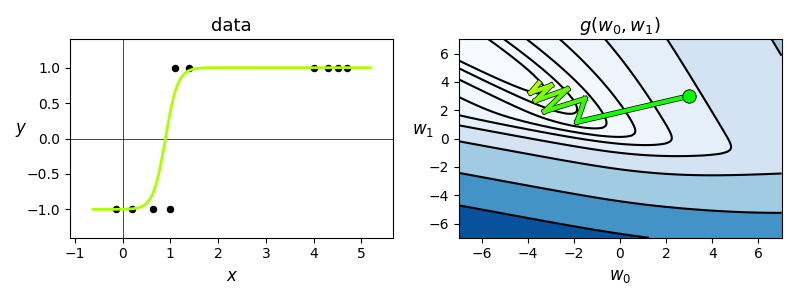
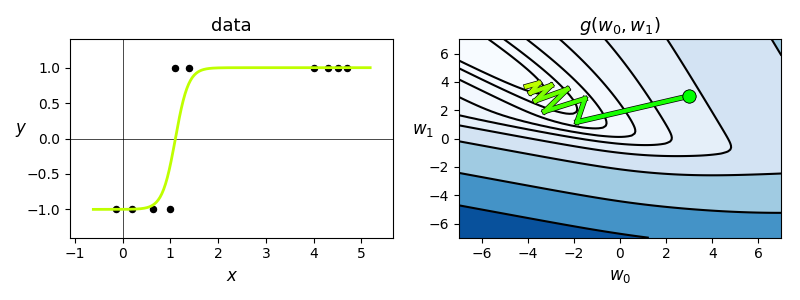
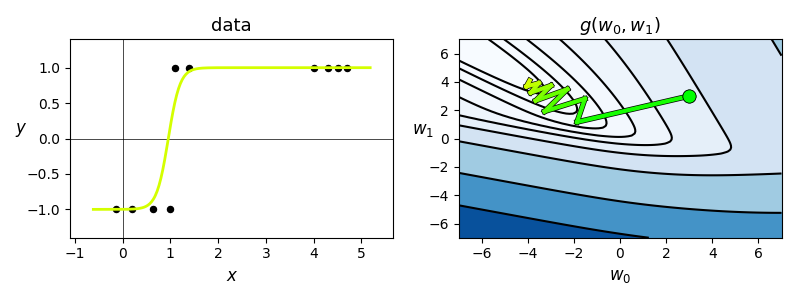
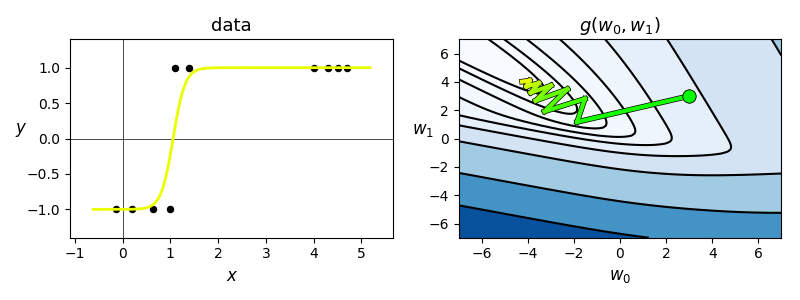
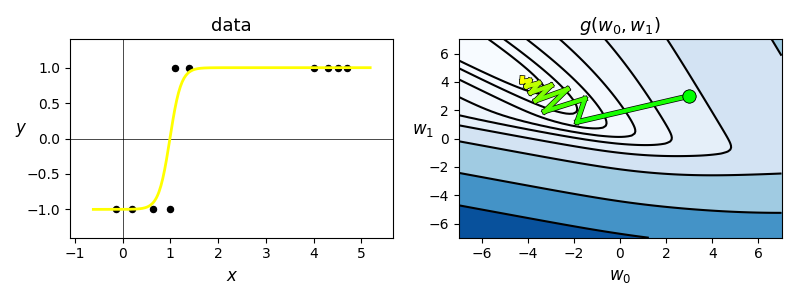
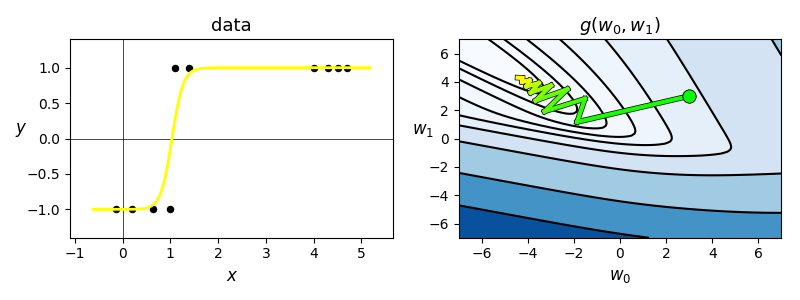
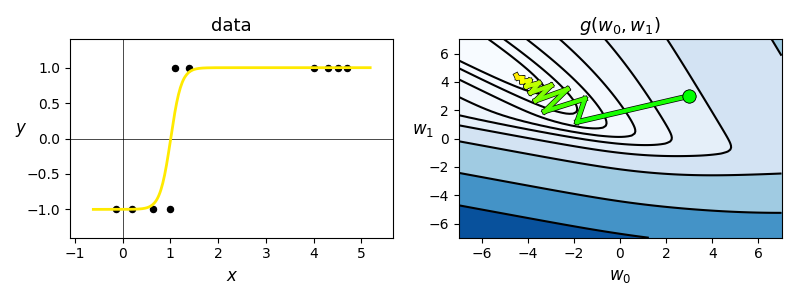
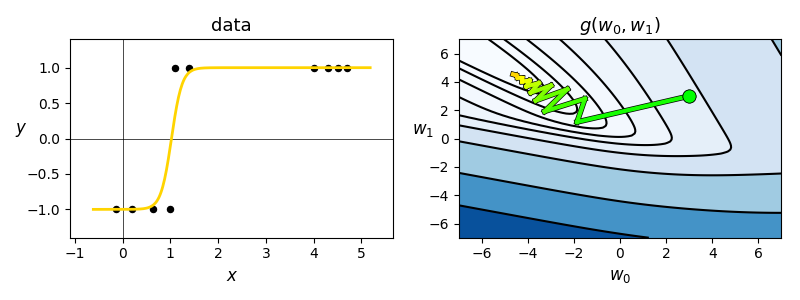
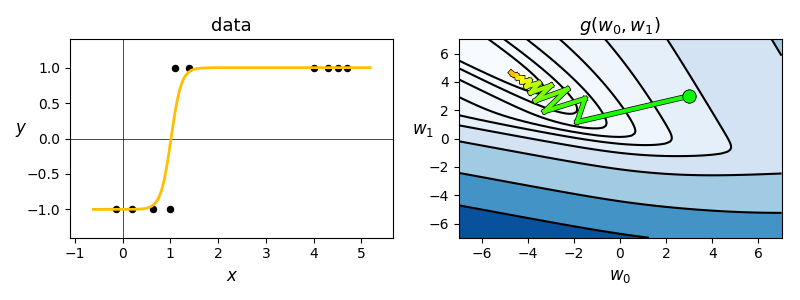
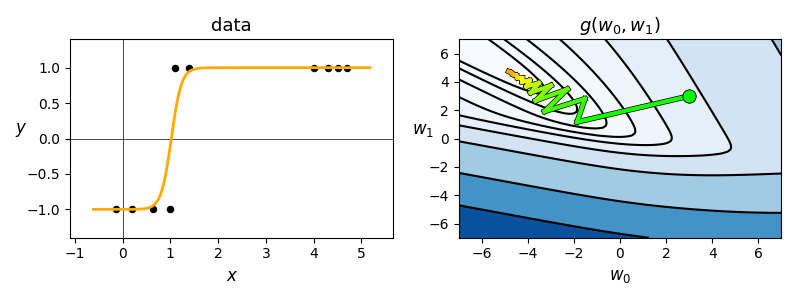
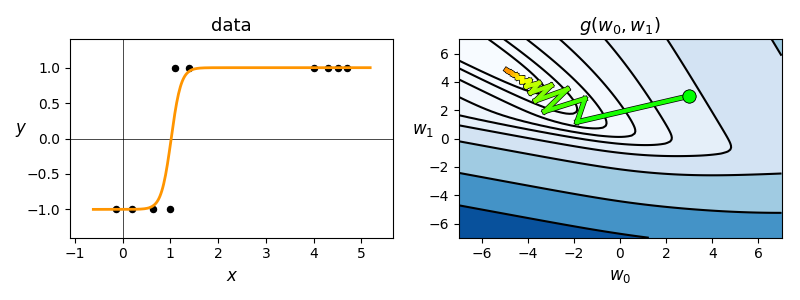
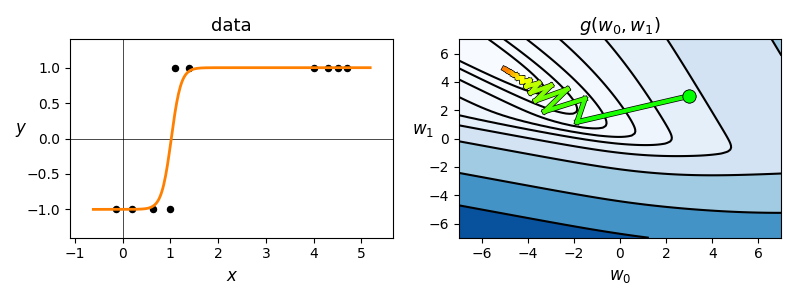
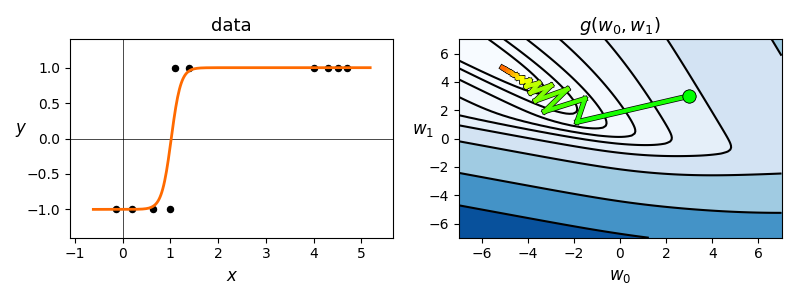
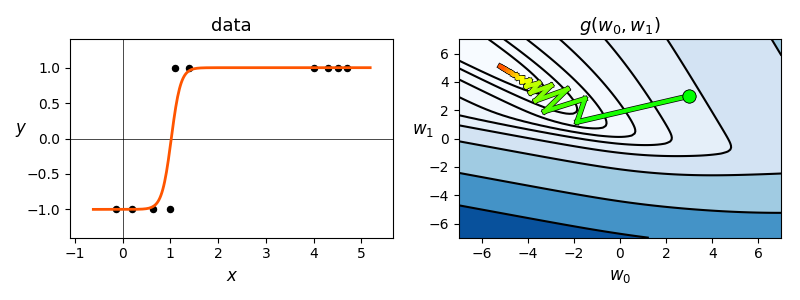
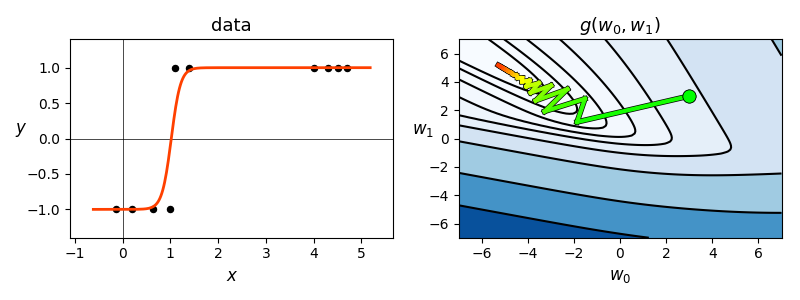
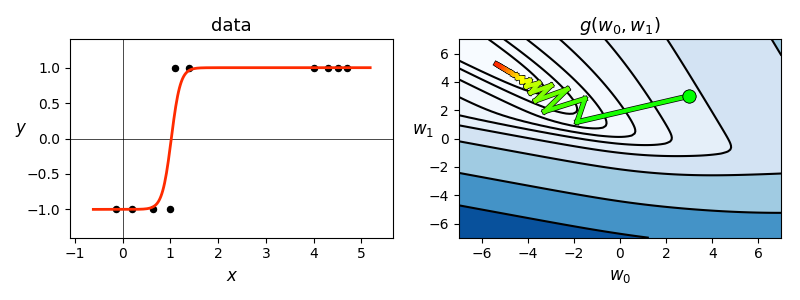
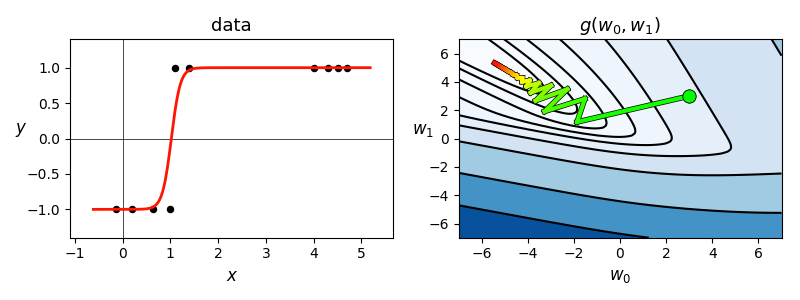
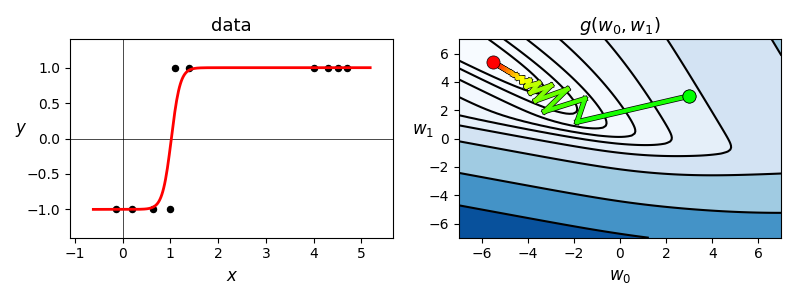

In [13]:
# create instance of logisic regression demo and load in data, cost function, and descent history
demo4 = superlearn.classification_2d_demos.Visualizer(data,softmax)

# animate descent process
demo4.animate_run(w_hist,num_contours = 25,viewmax = 7)

Running the algorithm until convergence here we can indeed reach the minimum of the cost function using gradient descent.  In the next Python cell we run the same algorithm from the initial point $w_0 = 20$ and $w_1 = -20$, even farther away from the global minimum for 900 steps. Indeed by this point we reach a point quite close to a global minimum of the function.

In [14]:
# run desired algo with initial point, max number of iterations, etc.,
w_hist = opt.gradient_descent(g = softmax,w = [20,-20],version = 'unnormalized',max_its = 900, alpha = 1)

The resulting fit here is comparable to the one found in the previous example, where we used the same initial point, steplength parameter $\alpha$, and number of steps to minimize the logistic Least Squares cost (using the normalized form of gradient descent). Here the fact that the magnitude of the gradient controls the length of each step means that steps near the solution become very small, and the algorithm requires a large number of them to converge.

<IPython.core.display.Javascript object>


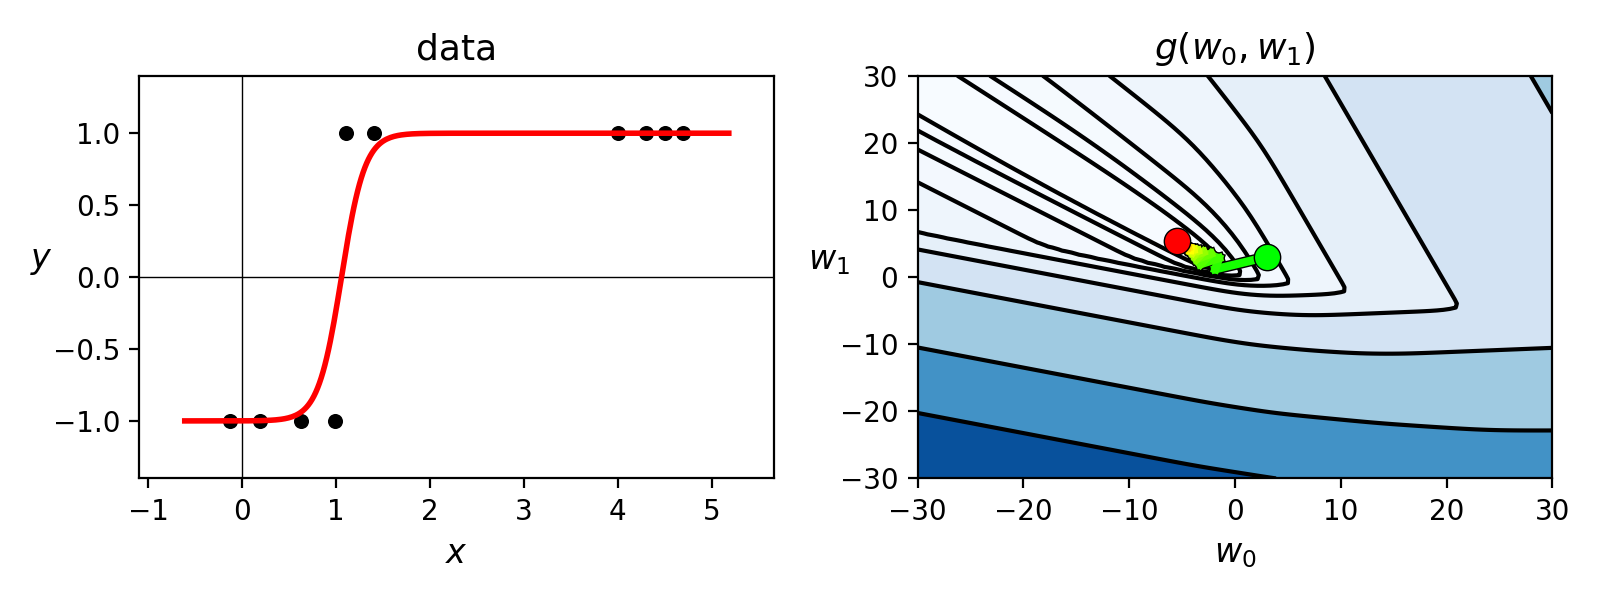

In [14]:
# create a static figure illustrating gradient descent steps 
demo4.static_fig(w_hist,num_contours = 25,viewmax = 30)

#### <span style="color:#a50e3e;">Example 5: </span> Using Newton's method to perform logistic regression using the softmax cost

Newton's method can also be used to minimize the softmax cost, taking just a few steps to reach a point near global minimum when properly initialized. In this example we illustrate the progress of 5 Newton steps beginning at the point $w_0 = 1$ and $w_1 = 1$.  Within 5 steps we have reached a point providing a very good fit to the data.

<IPython.core.display.Javascript object>


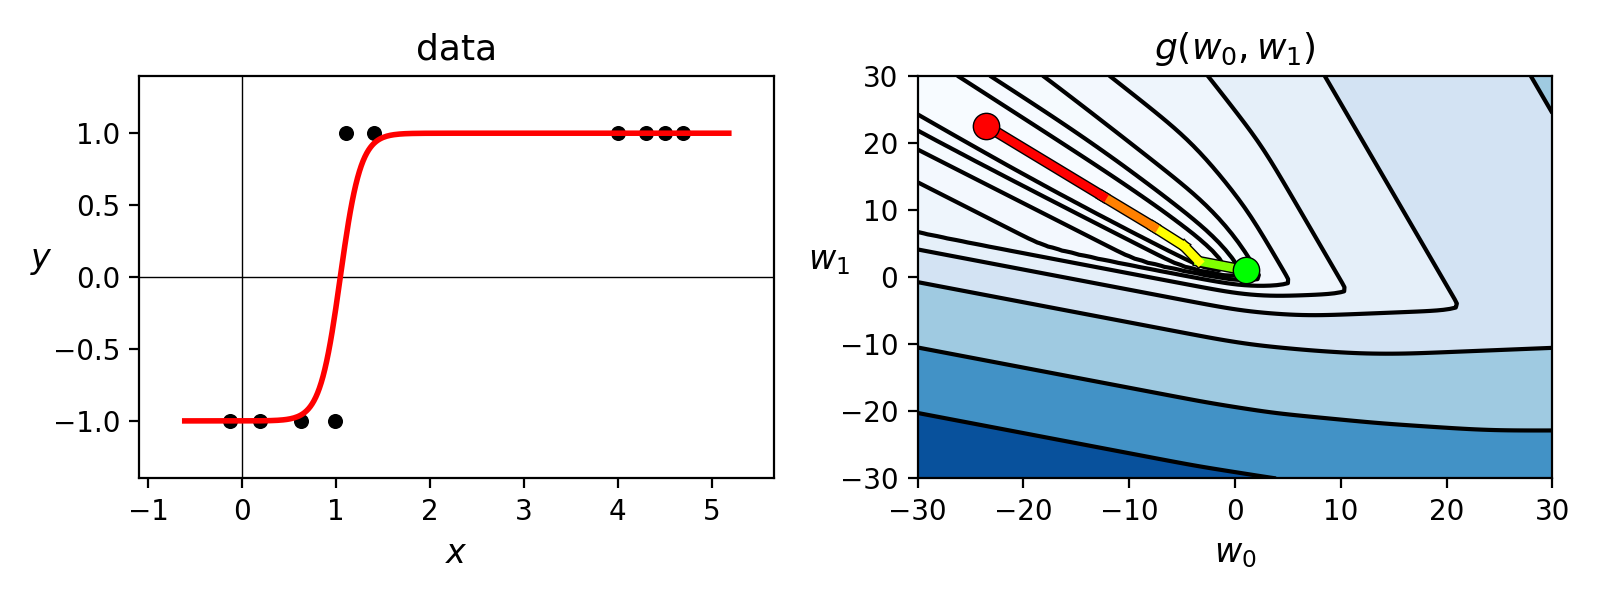

In [15]:
# run desired algo with initial point, max number of iterations, etc.,
w_hist = opt.newtons_method(g = softmax,w = [1,1],max_its = 5)

# create a static figure illustrating newton's method steps 
demo4.static_fig(w_hist,num_contours = 25,viewmax = 30)

---

Using the same logic that led us to the softmax cost when $N = 1$, we can derive the same set of desired equalities more generally with $N>1$ inputs  

\begin{equation}
\text{log}\left( 1 + e^{-y_p\left(w_{0}+ x_{1,p}w_{1} + x_{2,p}w_{2} + \cdots +x_{N,p}w_{N}\right)} \right)  = 1
\end{equation}

Using the more compact vector notation

\begin{equation}
\mathbf{w}=\left[\begin{array}{c}
w_{1}\\
w_{2}\\
\vdots\\
w_{N} 
\end{array}\right]
\,\,\,\,\,\text{and}\,\,\,\,\,\,
\mathbf{x}_p=\left[\begin{array}{c}
x_{1,p}\\
x_{2,p}\\
\vdots\\
x_{N,p}
\end{array}\right]
\end{equation}

we can write the above more compactly via the *inner product* as

\begin{equation}
\text{log}\left(1 + e^{-y_p^{\,}\left(w_0+\mathbf{x}_p^T \mathbf{w}_{\,}^{\,}\right)}\right)  = 1
\end{equation}

With this we can write the softmax cost function for logistic regression for general $N$ as 

\begin{equation}
g(w_0,\mathbf{w}) = \sum_{p=1}^P\text{log}\left(1 + e^{-y_p^{\,}\left(w_0+\mathbf{x}_p^T \mathbf{w}_{\,}^{\,}\right)}\right)
\end{equation}

Both the counting cost and logistic Least Squares cost (in equations (3) and (5) respectively) can be expressed for general $N$ dimensional input using this compact notation as well. Recall, how each of these costs correspond to a different *non-linear* surface being fit to the data in the input-output space: with the counting cost it is an ideal step function, while with logistic Least Squares and softmax it is a smooth approximation to the step function. However in all cases, the classifier separating the two classes in the input space of the problem is defined by  

\begin{equation}
w_0+\mathbf{x}^T \mathbf{w}_{\,}=0
\end{equation}

which by virtue of being a hyperplane (i.e., a linear model) makes logistic regression a *linear classifier*, regardless of the cost function employed. 

#### <span style="color:#a50e3e;">Example 6: </span> Constrained and regularized logistic regression

In applying Newton's method to minimize a cost function like the softmax we must be careful not to take too many steps, as in many cases the global minimum technically lies at infinity (this is where the tanh function perfectly resembles the sign function), and taking too many large steps towards it can lead to numerical issues as weights becomes extremely large. To see this phenomenon in action, lets first redefine the softmax cost in the next Python cell - this time for a general $N$ dimensional input. 

In [49]:
# the convex softmax cost function - for N > 2
def softmax(w):
    cost = 0
    for p in range(0,len(y)):
        x_p = x[p,:]
        y_p = y[p]
        a_p = w[0] + sum([a*b for a,b in zip(w[1:],x_p)])
        cost += np.log(1 + np.exp(-y_p*a_p)) 
    return cost 

With our cost function defined we now run Newton's method using the same initialization as in the previous example, but this time for twice as many Newton steps, i.e., $10$.

<IPython.core.display.Javascript object>


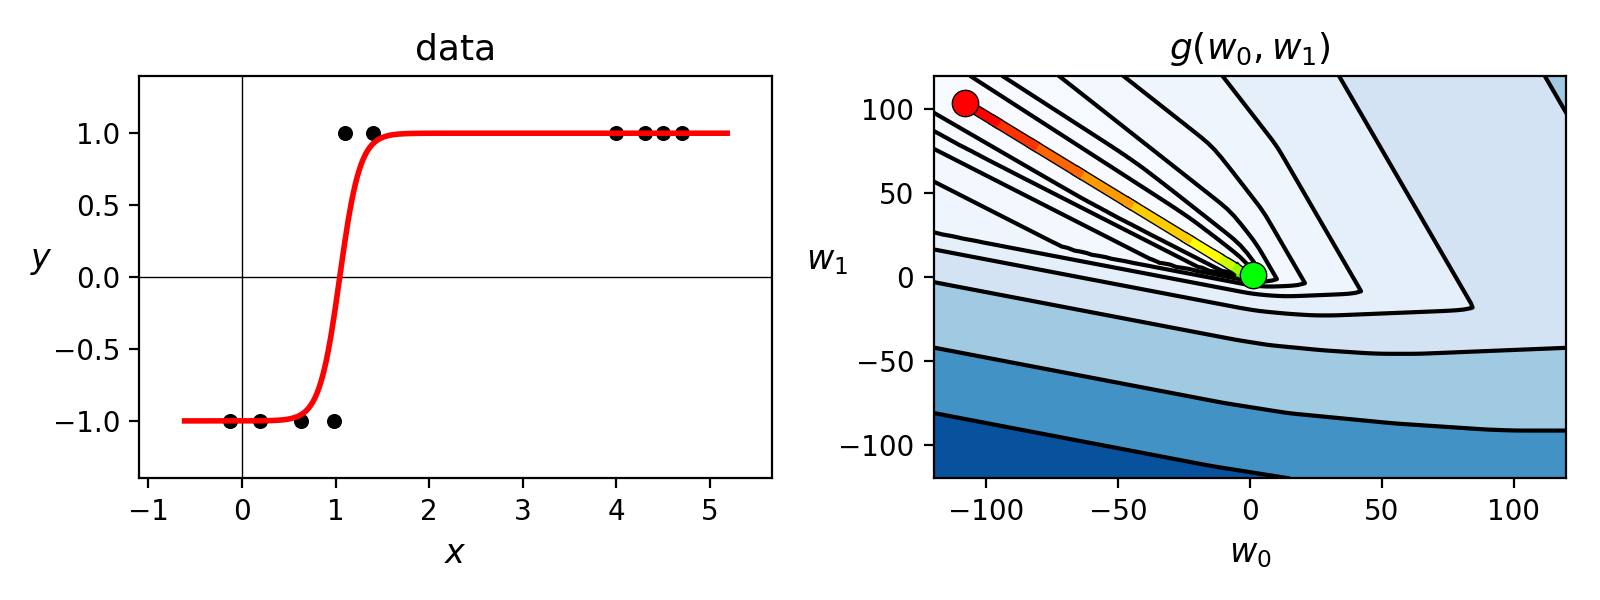

In [50]:
# load in demo
demo5 = superlearn.classification_2d_demos.Visualizer(data,softmax)

# declare an instance of our current our optimizers
opt = superlearn.optimimzers.MyOptimizers()

# run desired algo with initial point, max number of iterations, etc.
w_hist = opt.newtons_method(g = softmax,w = np.asarray([1.0,1.0]),max_its = 10)

# create a static figure illustrating newton's method steps 
demo5.static_fig(w_hist,num_contours = 25, viewmax = 120)

Notice how both weights $w_0$ and $w_1$ keep growing large as we take more Newton steps. A general way to deal with this issue is to make sure the normal vector of the separating hyperplane has unit length, giving us a constrained version of our problem

\begin{equation}
\begin{aligned}
\underset{w_0,\,\mathbf{w}}{\,\,\,\,\,\mbox{minimize}\,\,\,} & \,\,\,\, \sum_{p=1}^P\text{log}\left(1 + e^{-y_p\left(w_0 + \mathbf{x}_p^T \mathbf{w}\right)}\right)\\
\mbox{subject to}\,\,\, & \,\,\,\,\, \left \Vert \mathbf{w} \right \Vert_2^2 = 1
\end{aligned}
\end{equation}

One way of solving this problem is via *projected gradient*.  Another way is to *relax* the problem, forming the *regularized* form of losgistic regression

\begin{equation}
\underset{w_0,\,\mathbf{w}}{\text{minimize}} \,\,\, \sum_{p=1}^P\text{log}\left(1 + e^{-y_p\left(w_0 + \mathbf{x}_p \mathbf{w}\right)}\right) + \lambda\, \left \Vert \mathbf{w} \right \Vert_2^2 \\
\end{equation}

where setting the regularization parameter $\lambda$ to a typically small positive value prevents the weights in the normal vector from exploding. We set $\lambda$ to $10^{-3}$ in the Python cell below and form the regularized softmax cost. 

In [53]:
# the convex softmax cost function - for N > 2
lam = 10**(-3)
def regularized_softmax(w):
    cost = 0
    for p in range(0,len(y)):
        x_p = x[p,:]
        y_p = y[p]
        a_p = w[0] + sum([a*b for a,b in zip(w[1:],x_p)])
        cost += np.log(1 + np.exp(-y_p*a_p)) 
    return cost + lam*sum([a**2 for a in w[1:]])

We now run Newton's method using the same initialization and number of Newton steps as with the (unregularized) softmax cost above and plot the results.

<IPython.core.display.Javascript object>


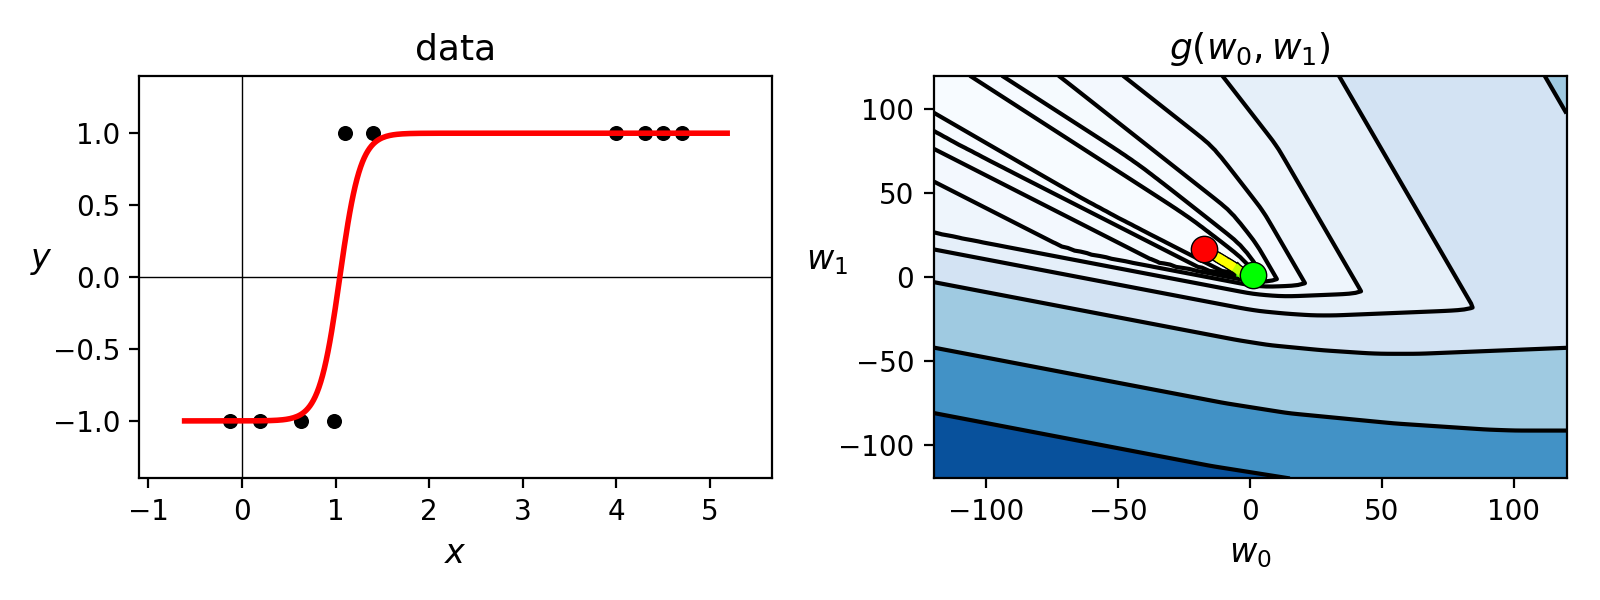

In [54]:
# load in demo
demo6 = superlearn.classification_2d_demos.Visualizer(data,softmax)

# declare an instance of our current our optimizers
opt = superlearn.optimimzers.MyOptimizers()

# run desired algo with initial point, max number of iterations, etc.
w_hist = opt.newtons_method(g = regularized_softmax,w = np.asarray([1.0,1.0]),max_its = 10)

# create a static figure illustrating newton's method steps 
demo6.static_fig(w_hist,num_contours = 25,viewmax = 120)

As expected, Newton steps are much smaller after regularization. 

#### <span style="color:#a50e3e;">Example 7: </span>  Noisy classification datasets are so typical they are almost the norm 

In this example we will minimize the softmax cost to perform logistic regression on the following two-class dataset.  This multi-input ($N = 2$) dataset has 100 points whose two classes cannot be perfectly separated by any line (and whose points cannot be perfectly fit using a tanh or even sign function).  In the left panel we show the data in three dimensions, and in the right panel we show the data from above in the 'separator' view.  

In [16]:
# load in dataset
data = np.loadtxt('../../mlrefined_datasets/superlearn_datasets/3d_classification_data_v0.csv',delimiter = ',')

<IPython.core.display.Javascript object>


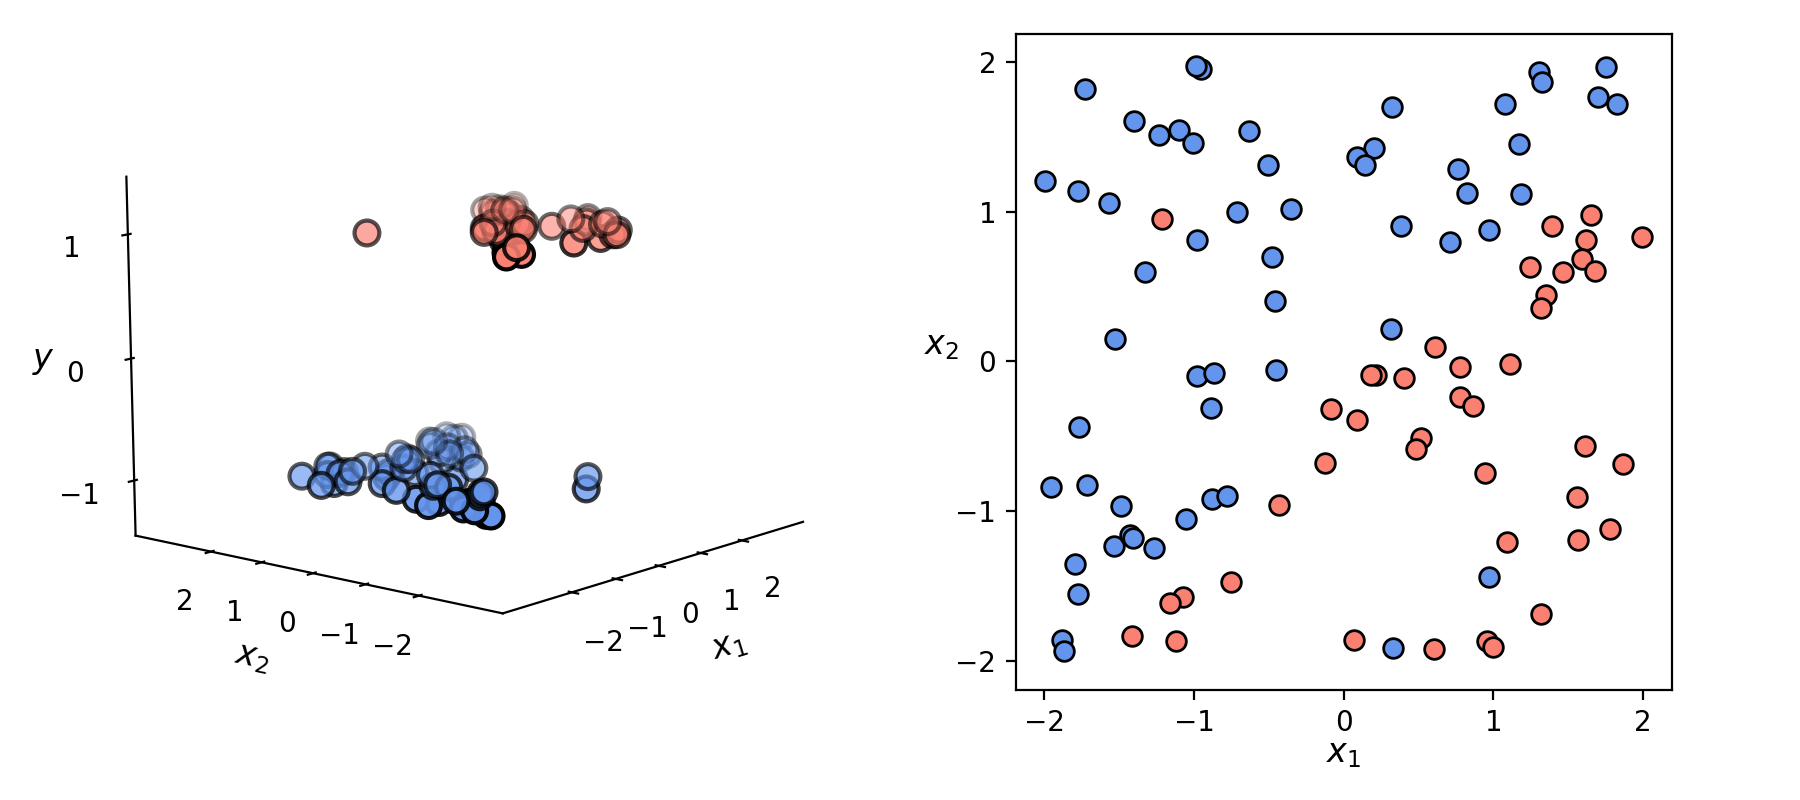

In [17]:
# create instance of linear regression demo, used below and in the next examples
demo7 = superlearn.classification_3d_demos.Visualizer(data)

# plot data
demo7.plot_data(view = [15,-140])

As you can see, there are three points here (two blue points and one red points) that look like they are on 'the wrong side'. Other than these 'noisy' points the two classes look like they can be very well fit with our nonlinear regressor $\text{tanh}\left(w_0 + w_1x_1 + w_2x_2\right)$ in the left panel and at the same time separated by the line $w_0 + w_1x_1 + w_2x_2 = 0$ in the right panel - provided the weights are tuned properly.  Note: in the classification context a 'noisy' point is one that has an incorrect label.  Two class classification datasets typically have noise of this kind (just as we saw linear regression datasets have their own version of noise) and are not perfectly separable by a hyperplane.

> In the context of classification a 'noisy' point is one that has an incorrect label.  Two class classification datasets typically have noise of this kind (just as we saw linear regression datasets have their own version of noise) and are not perfectly separable by a hyperplane.

In the next cell we generalize our Python implementation of the softmax cost to deal with input of arbitrary dimension.

In [18]:
# define the input and output of our dataset - assuming arbitrary N > 2 here
x = data[:,:-1]
y = data[:,-1]
y.shape = (len(y),1)

In [21]:
# the convex softmax cost function - for N > 2
def softmax(w):
    cost = 0
    for p in range(0,len(y)):
        x_p = x[p,:]
        y_p = y[p]
        a_p = w[0] + sum([a*b for a,b in zip(w[1:],x_p)])
        cost += np.log(1 + np.exp(-y_p*a_p))
    return cost

In the next Python cell we run Newton's method for 5 iterations (starting at a random initialization) on this dataset using the softmax cost function. 

In [22]:
# declare an instance of our current our optimizers
opt = superlearn.optimimzers.MyOptimizers()

# run desired algo with initial point, max number of iterations, etc.,
w_hist = opt.newtons_method(g = softmax,w = np.random.randn(3,1),max_its = 5)

In the next Python cell we plot the trained logistic function. In the left panel the dataset is shown in three dimensions, along with tanh surface fit. We also show draw the separator or *decision boundary* in the plane $y = 0$.  This plane shows the linear separator (where the tanh surface is zero) and is colored to indicate which of the input are determined to be of class $-1$ (the region of space colored light blue) and $+1$ (the region of space colored light red). In the right panel we plot the data, separator, and classified regions colored in the same way from the 'separator' view.  Here we can easily identify three points that have been misclassified - our three 'on the wrong side' points (the two blue points in the red region, and the one red point in the blue region).

<IPython.core.display.Javascript object>


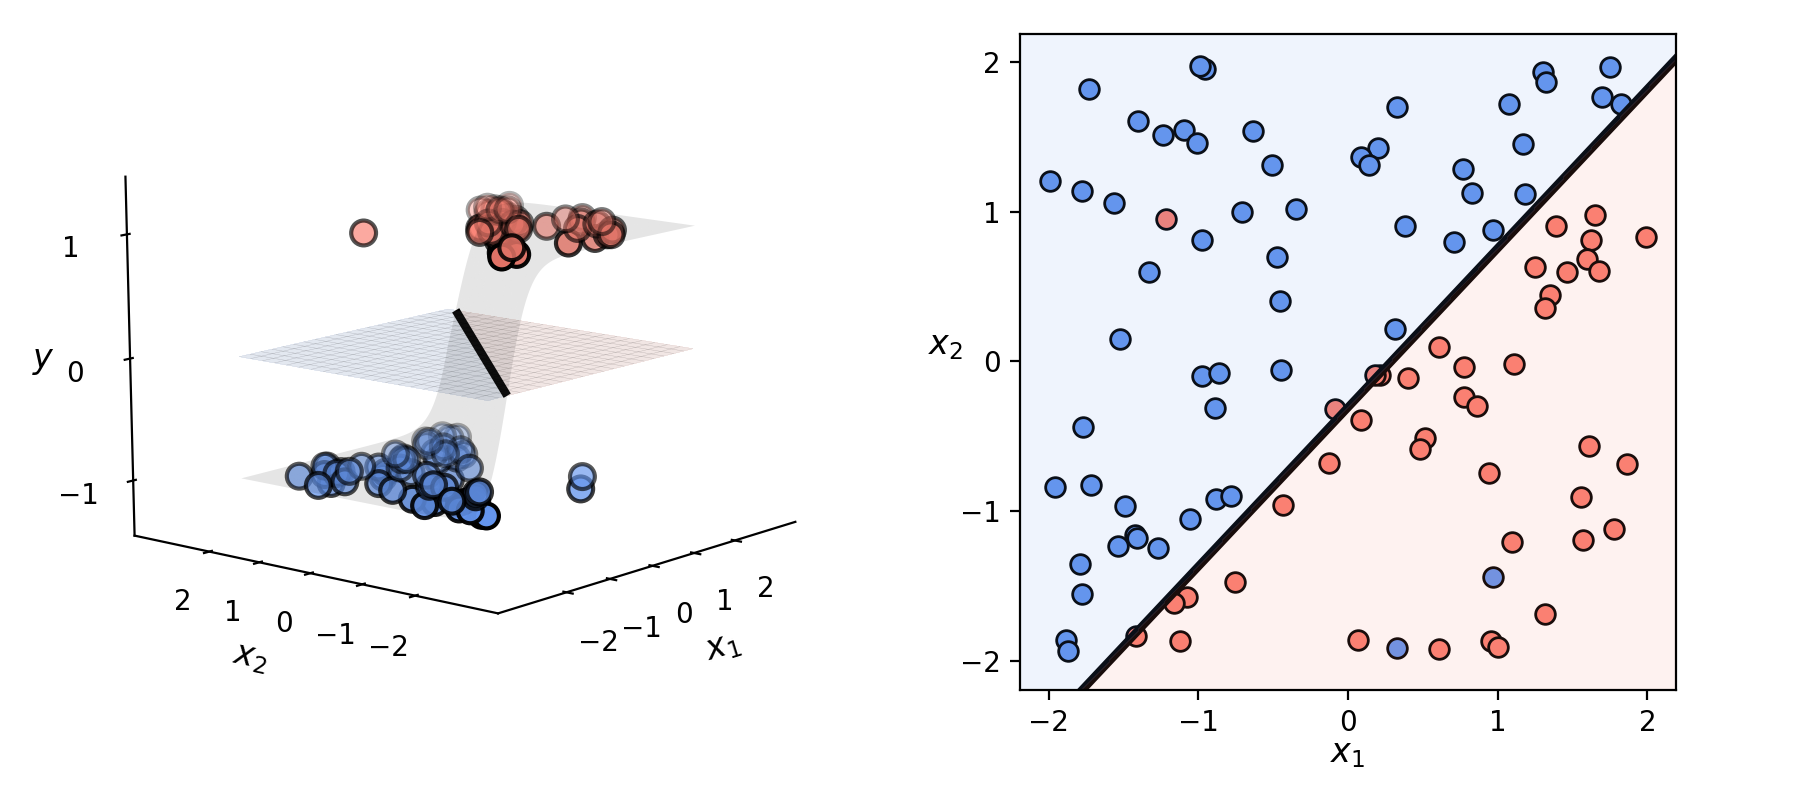

In [23]:
# create instance of 3d demos
demo8 = superlearn.classification_3d_demos.Visualizer(data)

# draw the final results
demo8.static_fig(w_hist,view = [15,-140])

As another example, let us again fit logistic regression to the following dataset.

In [24]:
# load in dataset
data = np.loadtxt('../../mlrefined_datasets/superlearn_datasets/3d_classification_data_v2.csv',delimiter = ',')

<IPython.core.display.Javascript object>


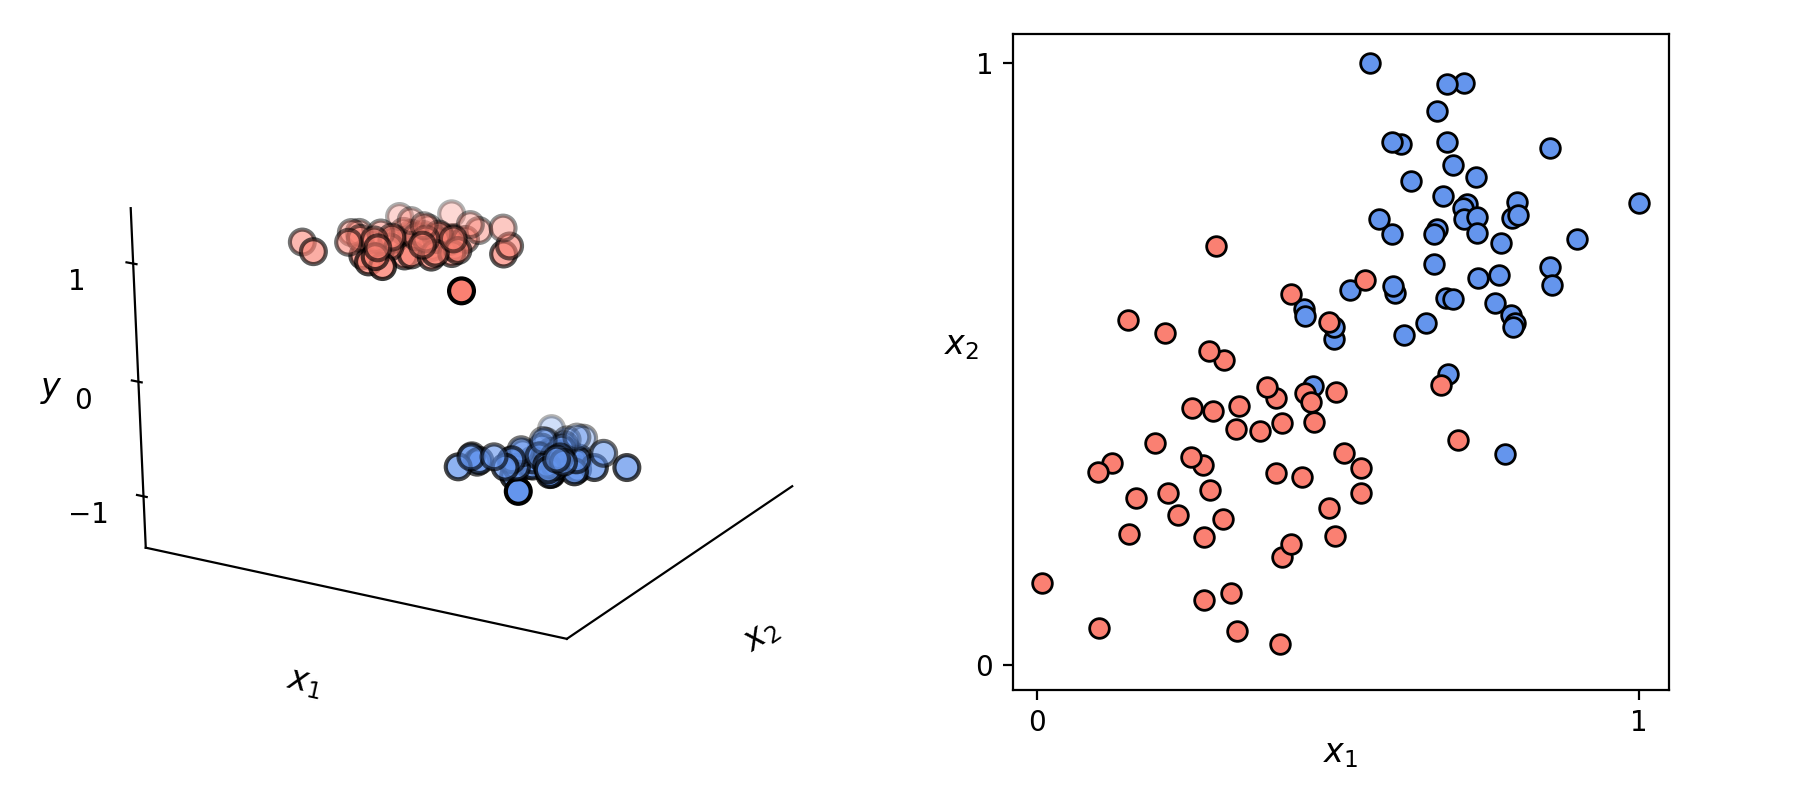

In [25]:
# create instance of linear regression demo, used below and in the next examples
demo9 = superlearn.classification_3d_demos.Visualizer(data)

# plot data
demo9.plot_data(view = [25,-60])

This one still looks like it can be roughly separated by a line, but each class has more noise and so we will have more misclassifications even when the ideal line is found.

In [26]:
# define the input and output of our dataset - assuming arbitrary N > 1 here
x = data[:,:-1]
y = data[:,-1]
y.shape = (len(y),1)

In [27]:
# declare an instance of our current our optimizers
opt = superlearn.optimimzers.MyOptimizers()

# run desired algo with initial point, max number of iterations, etc.,
w_hist = opt.newtons_method(g = softmax,w = np.random.randn(3,1),max_its = 5)

Now we plot the learned logistic regressor/separator as previously. As predicted, the fit is not perfect (it cannot be in this instance), but given the dataset it does a fine job.

<IPython.core.display.Javascript object>


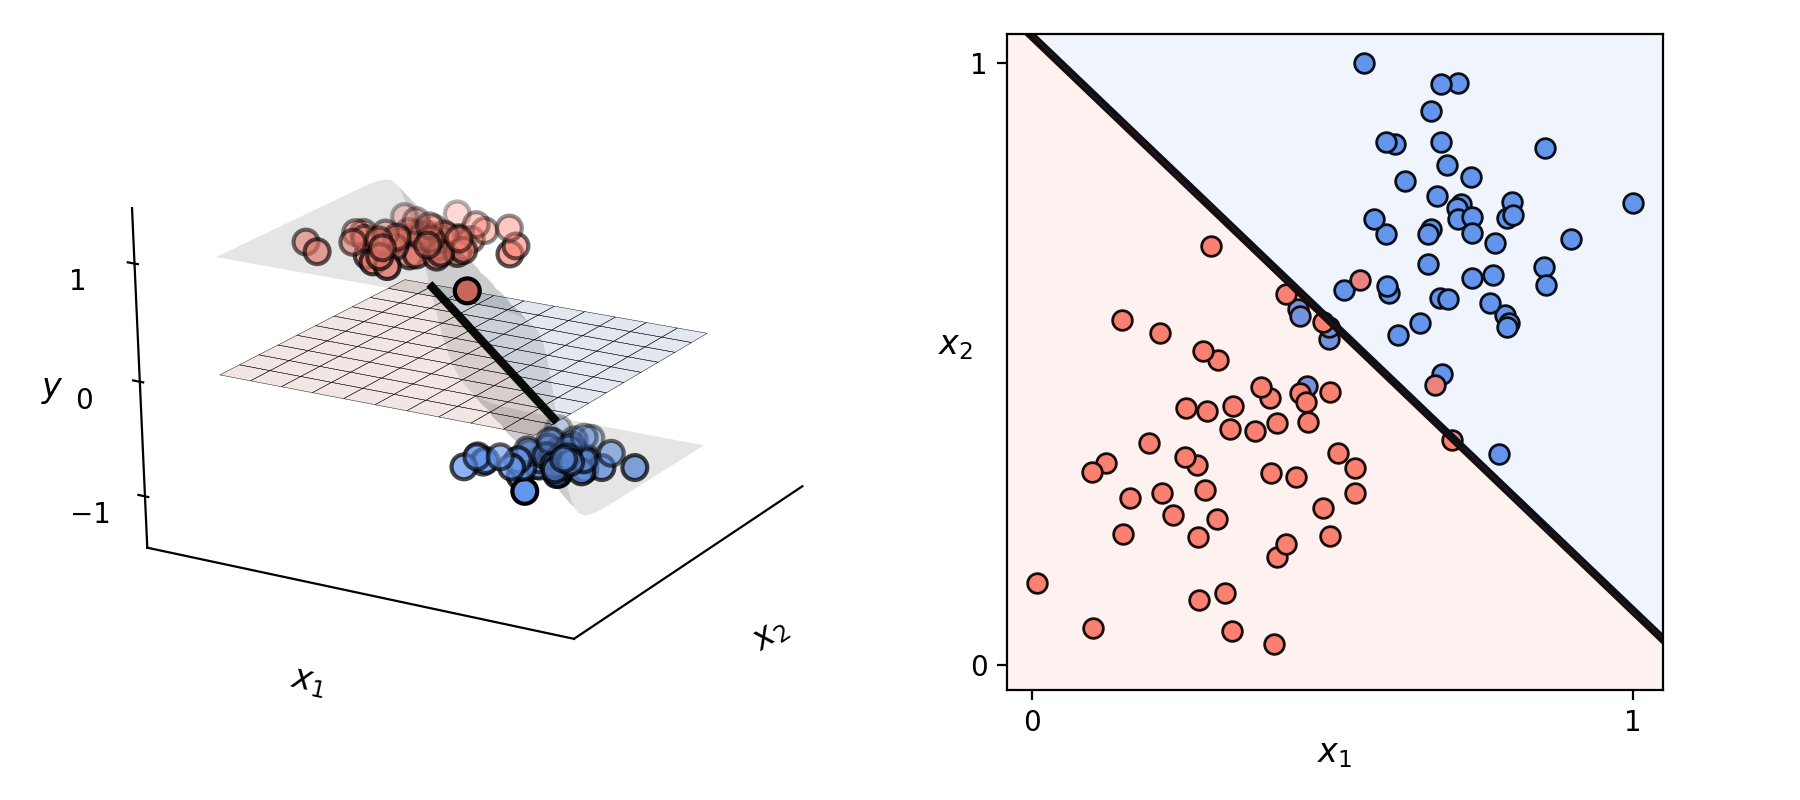

In [42]:
# create instance of 3d demos
demo10 = superlearn.classification_3d_demos.Visualizer(data)

# draw the final results
demo10.static_fig(w_hist,view = [25,-60])

#### <span style="color:#a50e3e;">Example 8: </span>  Closed form computation of gradient and Hessian for softmax cost function

As an alternative to using an automatic differentiator one can 'hard code' the gradient and Hessian for use with gradient descent and Newton's method. Using the more compact notation

\begin{equation}
\widetilde{\mathbf{w}}=\left[\begin{array}{c}
w_{0}\\
\mathbf{w}
\end{array}\right]
\,\,\,\,\text{and}\,\,\,\,\,
\widetilde{\mathbf{x}}_{p}=\left[\begin{array}{c}
1\\
\mathbf{x}_{p}
\end{array}\right]
\end{equation}

one can easily compute the general form of the gradient by hand (using the derivative rules detailed in our *vital elements of calculus series*) to be

\begin{equation}
\nabla g\left(\widetilde{\mathbf{w}}\right) = - \sum_{p = 1}^P \frac{e^{-\,y_p^{\,} \widetilde{\mathbf{x}}_p^T\widetilde{\mathbf{w}}_{\,}^{\,}}}{1 + e^{-\,y_p^{\,} \widetilde{\mathbf{x}}_p^T\widetilde{\mathbf{w}}_{\,}^{\,}}}\, y_p^{\,} \widetilde{\mathbf{x}}_p^{\,}
\end{equation}

which is often written equivalently as

\begin{equation}
\nabla g\left(\widetilde{\mathbf{w}}\right) = - \sum_{p = 1}^P \frac{1}{1 + e^{\,y_p^{\,} \widetilde{\mathbf{x}}_p^T\widetilde{\mathbf{w}}_{\,}^{\,}}}\, y_p^{\,} \widetilde{\mathbf{x}}_p^{\,}
\end{equation} 

Writing the gradient in this way also helps avoid numerical problems associated with using the exponential function on a modern computer. This is due to the exponential
'overflowing' with large exponents, e.g., $e^{1000}$, as these numbers are too large to store explicitly on the computer and so are
represented symbolically as $\infty$. This becomes a problem when evaluating $\frac{e^{1000}}{1+e^{1000}}$
which, although basically equal to the value $1$, is thought of by the computer to be a NaN (not a number) as it thinks $ $$\frac{e^{1000}}{1+e^{1000}}=\frac{\infty}{\infty}$
which is undefined. By writing each summand of the gradient such that it has an exponential in its denominator only, we avoid the problem
of dividing two overflowing exponentials. The overflowing exponential issue is discussed further in the Chapter exercises, as it is also
something to keep in mind when both choosing an initial point for gradient descent/Newton's method as well as recording the value of the softmax cost at each iteration.

For the same reasons the Hessian of the softmax (for use with Newton's method) is often written as

\begin{equation}
\nabla^2 g\left(\widetilde{\mathbf{w}}\right) =  \sum_{p = 1}^P \left( \frac{1}{1 + e^{\,y_p^{\,} \widetilde{\mathbf{x}}_p^T\widetilde{\mathbf{w}}_{\,}^{\,}}} \right) \left( 1 - \frac{1}{1 + e^{\,y_p^{\,} \widetilde{\mathbf{x}}_p^T\widetilde{\mathbf{w}}_{\,}^{\,}}} \right) \, \widetilde{\mathbf{x}}_p^{\,}\widetilde{\mathbf{x}}_p^T
\end{equation}

## 1.4  Classification nomenclature and predictions

Regardless of the cost function we use to perform logistic regression - tanh Least Squares or softmax cost - once the weights have been tuned it is generally referred to as a *trained classifier*. 

> Regardless of the cost function we use to perform logistic regression - tanh Least Squares or softmax cost - once the weights have been tuned it is generally referred to as a *trained classifier*. 

Moreover, remember that the general goal with logistic regression is to learn a set of $N+1$ parameters - the optimal bias $w_0^{\star}$ as well as $N$ weights in $\mathbf{w}^{\star}$ - so that the tanh function

\begin{equation}
f(\mathbf{x}) = \text{tanh}\left(w_0^{\star}+\mathbf{x}^{T}\mathbf{w}^{\star}\right)
\end{equation}

fits the given dataset as best as possible.  This was as close as we could get to directly fitting the discontinuous step function  $\text{sign}\left(w_0^{\star}+\mathbf{x}^{T}\mathbf{w}^{\star}\right)$ directly to the data.  

Importantly, this function (sometimes called a *decision function*) provides us with a learned linear *separator* or *decision boundary* where it intersects the plane $y = 0$.  This is where

\begin{equation}
w_0^{\star}+\mathbf{x}^{T}\mathbf{w}^{\star} = 0
\end{equation}

This boundary is used to make predictions about every point in the space.  If a point $\mathbf{x}$ lies above it (i.e., if $w_0^{\star}+\mathbf{x}^{T}\mathbf{w}^{\star} > 0$) then this point has a predicted label $+1$, likewise if the point lies below (i.e., if $w_0^{\star}+\mathbf{x}^{T}\mathbf{w}^{\star} < 0$) the point has a predicted label $-1$.  If a point lies precisely on the boundary we cannot say which class it belongs to (in such cases one is typically assigned to the point at random).  Wrapping together these conditions we can say that to predict the label of an input point $\mathbf{x}_{\textrm{new}}$ we evaluate its weighted version using the sign function.  Denoting the predicted label $y_{\textrm{new}}$ we have

\begin{equation}
\text{sign}\,\left(w_0^{\star}+\mathbf{x}_{\textrm{new}}^{T}\mathbf{w}^{\star}\right) = y_{\textrm{new}}
\end{equation}

> Once weights are properly tuned the *decision boundary* $w_0^{\star}+\mathbf{x}^{T}\mathbf{w}^{\star} = 0$ provides a rule for determining which points - according to the classifier - belong to class $+1$ or $-1$.  This is done by  computing $\text{sign}\,\left(w_0^{\star}+\mathbf{x}_{\textrm{new}}^{T}\mathbf{w}^{\star}\right)$.

<figure>
  <img src= '../../mlrefined_images/superlearn_images/Fig_4_6.png' width="80%" height="80%" alt=""/>
  <figcaption>   
<strong>Figure 3:</strong> <em> Once a hyperplane has been learned to the current dataset with optimal parameters $w_0^{\star}$ and $\mathbf{w}^{\star}$, the label $y_{\textrm{new}}$ of a new point $\mathbf{x}_{\textrm{new}}$ can be predicted by simply checking which side of the boundary it lies on. In the illustration shown here $\mathbf{x}_{\textrm{new}}$ lies below the learned hyperplane, and as a result is given the label $y_{\textrm{new}}=\textrm{sign}\left(w_0^{\star}+\mathbf{x}_{\textrm{new}}^{T}\mathbf{w}^{\star}\right)=-1$. </em>  </figcaption> 
</figure>

## 1.5  Counting misclassifications and the accuracy of a trained classifier

Notice how because $y_p \in \{\pm 1\}$ that the error produced by the counting cost for a single point either equals $0$ when the prediction matches the true label, or $4$ when a misclassification occurs

\begin{equation}
\left(\text{sign}\left(w_0+\mathbf{x}_p^T\mathbf{w}_{\,}^{\,} \right) - y_p \right)^2 = \begin{cases}
0 \,\,\,\, \text{if} \,\,\,\text{sign}\left(w_0+\mathbf{x}_p^T\mathbf{w}_{\,}^{\,} \right) =  y_p \\
4 \,\,\,\, \text{else} \\
\end{cases}
\end{equation}

Therefore to count the total number of misclassifications of a trained classifier we can simply evaluate the counting cost, dividing by $4$ as 

\begin{equation}
\text{number of misclassifications} = \frac{1}{4}\sum_{p=1}^P \left(\text{sign}\left(w_0^{\star}+\mathbf{x}_p^T\mathbf{w}_{\,}^{\star} \right) - y_p \right)^2
\end{equation}

#### <span style="color:#a50e3e;">Example 9: </span> Comparing the softmax cost and the counting cost

Since the softmax cost is only our (convex) approximation to the counting cost it does not always track directly with the counting cost - and in particular the number of misclassifications - at each step of a descent run.  In this example we illustrate this using the second dataset from Example 6. The next Python cell below loads in this dataset and performs three runs of (unnormalized) gradient descent for 50 iterations each.  Each run has a random initial point but all three runs use the same steplength parameter $\alpha = 10^{-2}$.  

In the left panel the number of misclassifications is plotted per iteration of each run, while in the right panel the simultaneously measured value of the softmax cost function is shown.  Each run is color-coded to distinguish it from the other runs.

<IPython.core.display.Javascript object>


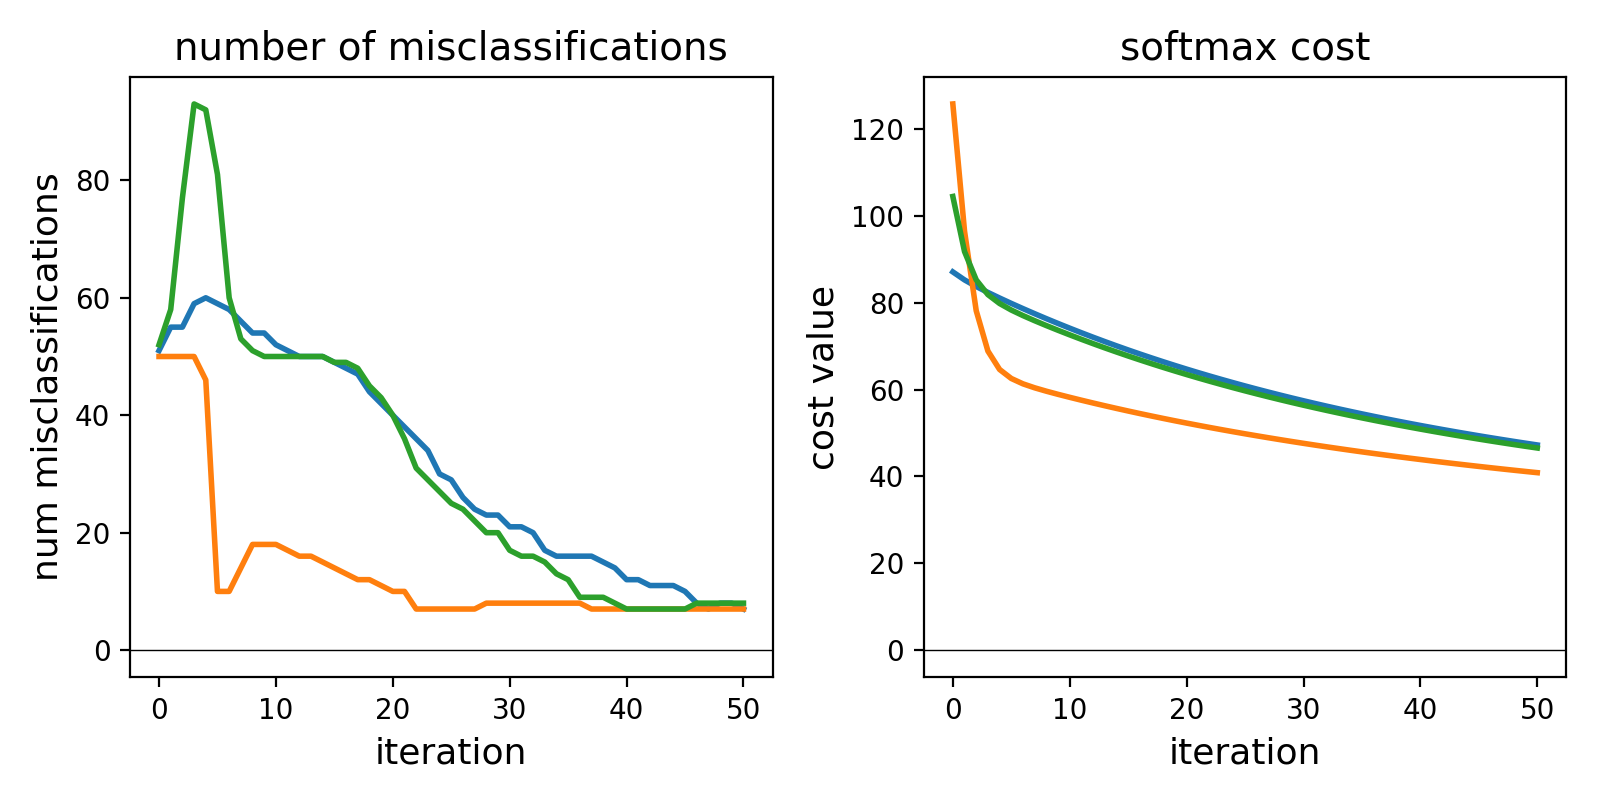

In [28]:
# load in dataset
data = np.loadtxt('../../mlrefined_datasets/superlearn_datasets/3d_classification_data_v2.csv',delimiter = ',')

# create instance of cost comparison demo
demo11 = superlearn.cost_comparisons.Visualizer(data)

# run 
demo11.compare_to_counting(cost = 'softmax',max_its = 50,num_runs = 3,alpha = 10**-2,algo = 'gradient_descent')

Comparing the left and right panels we can see that the number of misclassifications and softmax evaluations at each step of a gradient descent run do not perfectly track one another.  That is, it is not the case that just because the cost function value is decreasing that so too is the counting cost (number of misclassifications). Again, this occurs because our softmax cost is only an approximation of the true quantity we would like to minimize - the counting cost.

This has a useful practical implication: during optimization one should save the weight associated with the lowest *number of misclassifications* not the lowest cost value.

> During optimization of the softmax cost one should save the weight associated with the lowest *number of misclassifications* not the lowest cost value.

---

The simplest measure of how well a classifier has been trained on a set of $P$ training datapoints is its *accuracy*, which is the average number of points it classifies correctly.  We can compute this - for example - by taking the average evaluation of the *counting cost* 

\begin{equation}
\text{accuracy}= 1 - \frac{1}{4P}\sum_{p=1}^P \left(\text{sign}\left(w_0^{\star}+\mathbf{x}_p^T\mathbf{w}_{\,}^{\star} \right) - y_p \right)^2
\end{equation}

which ranges from 0 (no points classified correctly) to 1 (all points classified correctly).  This is not always the best measure of a learned classifier's efficacy as, for instance, it fails to capture the classifier's quality on a highly *imbalanced* dataset. We will discuss this issue later.

## 1.6 Logistic regression from a probabilistic perspective

We saw previously, in our post on linear regression, that one could re-derive the Least Squares solution to linear regression via a maximum likelihood approach. The same can be done here for logistic regression, leading to formation of a cost function equivalent to the softmax cost, as we detail below.

As with linear regression, we again make the assumption that the datapoints are statistically independent of each other, so that the likelihood can be written as 

\begin{equation}
{\cal L}=\prod_{p=1}^{P}{\cal P}\left(y=y_{p}\,|\,\mathbf{x}_{p},w_0,\mathbf{w}\right)
\end{equation}  

where ${\cal P}\left(y=y_{p}\,|\,\mathbf{x}_{p},w_0,\mathbf{w}\right)$ is the probability of the $p^{th}$ datapoint $\mathbf{x}_p$ having the label $y_p$ when the separating hyperplane is given by its defining parameters $w_0$ and $\mathbf{w}$. As pointed out previously in Subsection 1.1 where we chose $y_p \in\left\{−1,+1\right\}$, the class labels can take arbitrary (but distinct) values. With the probabilistic framework it is more convenient to replace $-1$ labels with $0$, so that $y_p \in\left\{0,1\right\}$ and we can write each product term in the likelihood compactly as


\begin{equation}
{\cal P}\left(y=y_{p}\,|\,\mathbf{x}_{p},w_0,\mathbf{w}\right)={\cal P}\left(y=1\,|\,\mathbf{x}_{p},w_0,\mathbf{w}\right)^{y_p}\,{\cal P}\left(y=0\,|\,\mathbf{x}_{p},w_0,\mathbf{w}\right)^{1-y_p}
\end{equation} 


Since $y_p$ takes only one of two values, we have that 

\begin{equation}
{\cal P}\left(y=0\,|\,\mathbf{x}_{p},w_0,\mathbf{w}\right)= 1-{\cal P}\left(y=1\,|\,\mathbf{x}_{p},w_0,\mathbf{w}\right)
\end{equation} 

giving the likelihood as 

\begin{equation}
{\cal L}=\prod_{p=1}^{P}{\cal P}\left(y=1\,|\,\mathbf{x}_{p},w_0,\mathbf{w}\right)^{y_p}\left[1-{\cal P}\left(y=1\,|\,\mathbf{x}_{p},w_0,\mathbf{w}\right)\right]^{1-y_p}
\end{equation}

which is now written only in terms of ${\cal P}\left(y=1\,|\,\mathbf{x}_{p},w_0,\mathbf{w}\right)$.  

Before proposing a mathematical form for this probability and attempting to maximize the resulting likelihood, recall from our geometric discussion of logistic regression in previous subsections that the separating hyperplane $w_0+\mathbf{x}^T\mathbf{w}=0$ divides the input space of the problem into two half-spaces with the one characterized by $w_0+\mathbf{x}^T\mathbf{w}>0$ encompassing the $y=1$ class, and the one characterized by $w_0+\mathbf{x}^T\mathbf{w}<0$ encompassing the $y=0$ (previously $y=-1$) class.

Thinking probabilistically, this means that a point $\mathbf{x}_p$ belongs to class $y=1$ with probability 1 when $w_0+\mathbf{x}_p^T\mathbf{w}>0$, and to class $y=0$ with probability 1 when $w_0+\mathbf{x}_p^T\mathbf{w}<0$. Focusing only on the positive class, we can then write

\begin{equation}
{\cal P}\left(y=1\,|\,\mathbf{x}_{p},w_0,\mathbf{w}\right)=\begin{cases}
1 \,\,\,\,\,\text{if} \,\, w_0+\mathbf{x}_p^T\mathbf{w}>0 \\
0 \,\,\,\,\,\text{else} \\
\end{cases}
\end{equation} 

This probability expression can itself be thought of as a step function - with steps of $1$ and $0$ - jumping from one step to the other when $w_0+\mathbf{x}_p^T\mathbf{w}$ changes sign.    

Although seemingly a proper probability, the expression in equation (29) cannot be used for any dataset that is not perfectly separable by a hyperplane, in which case any (inevitable) misclassification will send the entire likelihood in equation (28) to zero. Using the logistic sigmoid function $\sigma(\cdot)$ as a strictly positive approximation to the 0/1 step function, we can resolve this issue by writing    

\begin{equation}
{\cal P}\left(y=1\,|\,\mathbf{x}_{p},w_0,\mathbf{w}\right)=\sigma\left(w_0+\mathbf{x}_p^T\mathbf{w}\right)
\end{equation} 

which gives the likelihood as 

\begin{equation}
{\cal L}=\prod_{p=1}^{P}\sigma\left(w_0+\mathbf{x}_p^T\mathbf{w}\right)^{y_p}\left[1-\sigma\left(w_0+\mathbf{x}_p^T\mathbf{w}\right)\right]^{1-y_p}
\end{equation}

and the corresponding negative log-likelihood as 


\begin{equation}
g\left(w_0,\mathbf{w}\right)=-\sum_{p=1}^{P}y_p\,\text{log}\,\sigma\left(w_0+\mathbf{x}_p^T\mathbf{w}\right)+\left(1-y_p\right)\text{log}\,\left(1-\sigma\left(w_0+\mathbf{x}_p^T\mathbf{w}\right)\right)
\end{equation}  

The cost function in equation (32) is typically referred to as *the cross-entropy cost* which is equivalent to the softmax cost when using $\pm1$ labels. To see why this is the case, notice that when $y_p=0$ the cross-entropy term for $\mathbf{x}_p$ reduces to 

\begin{equation}
-\text{log}\,\left(1-\sigma\left(w_0+\mathbf{x}_p^T\mathbf{w}\right)\right)
\end{equation}  

which is identical to the softmax term for $\mathbf{x}_p$ 

\begin{equation}
\text{log}\,\left(1+e^{-y_p\left(w_0+\mathbf{x}_p^T\mathbf{w}\right)}\right)
\end{equation}  


when $y_p=-1$, using the definition of the sigmoid function as

\begin{equation}
\sigma\left(s\right)=\frac{1}{1+e^{-s}}
\end{equation}  



Similarly one can show that when $y_p =1$ with both costs, the cross-entropy term 


\begin{equation}
-\text{log}\,\sigma\left(w_0+\mathbf{x}_p^T\mathbf{w}\right)
\end{equation}  

and the softmax term 

\begin{equation}
\text{log}\,\left(1+e^{-y_p\left(w_0+\mathbf{x}_p^T\mathbf{w}\right)}\right)
\end{equation}  



are again the same, proving the two cost functions are indeed equivalent. 

> The maximum likelihood approach to logistic regression leads to the cross-entropy loss, which is equivalent to the softmax cost (after simple reassignment of class labels).   

The probabilistic perspective on logistic regression, by design, enables us to assign a probability score to each point in our dataset once the optimal hyperplane parameters $w_0^{\star}$ and $\mathbf{w}^{\star}$ are learned. Specifically, the probability of the point $\mathbf{x}_p$ belonging to class $y=1$ is given by

\begin{equation}
{\cal P}\left(y=1\,|\,\mathbf{x}_{p},w_0^{\star},\mathbf{w}^{\star}\right)=\sigma\left(w_0^{\star}+\mathbf{x}_p^T\mathbf{w}^{\star}\right)
\end{equation} 

This probability score can be interpreted as how 'confident' our classifier is in predicting a label of $y=1$ for $\mathbf{x}_p$. If $w_0^{\star}+\mathbf{x}_p^T\mathbf{w}^{\star}>0$, the larger this evaluation gets the closer the probability gets to a value of 1, and hence the more confident we are of xp belonging to class y=1. On the other hand, when $w_0^{\star}+\mathbf{x}_p^T\mathbf{w}^{\star}<0$ the probability of $y=1$ falls below $50\%$ and as the evaluation gets smaller the probability approaches zero, while at the same time its complement - the probability of $y=0$ - gets closer to 1.       

This notion of confidence - which can be particularly useful when dealing with new datapoints whose labels are not known a priori - is strongly connected to the geometric notion of distance from the separating hyperplane. The figure below shows two datapoints $\mathbf{x}_p$ and $\mathbf{x}_q$, both lying in the positive half-space created by the hyperplane $w_0+\mathbf{x}^T\mathbf{w}=0$, whose distances from the hyperplane can be calculated - using simple algebra - as $\frac{w_{0}+\mathbf{x}_{p}^{T}\mathbf{w}}{\left\Vert \mathbf{w}\right\Vert _{2}}$ and $\frac{w_{0}+\mathbf{x}_{q}^{T}\mathbf{w}}{\left\Vert \mathbf{w}\right\Vert _{2}}$, respectively.      

<figure>
  <img src= '../../mlrefined_images/superlearn_images/distance_to_boundary.png' width="70%" height="80%" alt=""/>
  <figcaption>   
<strong>Figure 4:</strong> <em> Visual representation of the distance to the hyperplane $w_0+\mathbf{x}^T\mathbf{w}=0$, from two points $\mathbf{x}_p$ and $\mathbf{x}_q$ lying above it. </em>  </figcaption> 
</figure>

Ignoring the common denominator $\left\Vert \mathbf{w}\right\Vert _{2}$, the distance from a point to the hyperplane is proportional to its evaluation using the hyperplane, which is then mapped to a number between 0 and 1 via the sigmoid function, producing a valid probability score.  

> The notion of class probability is closely connected to the geometric notion of distance to the decision boundary. The farther a point is from the decision boundary the more confident the classier becomes about its predicted label. Conversely, as we get closer to the boundary, the classifier loses 'confidence' and the probability scores for each class get closer in value. In the most extreme case where the point lies precisely in the separating hyperplane, the distance is zero, giving a 50-50 probability of the point belonging to either class.

## 1.7 Appendix

### Proof that the softmax cost function is convex

To show that the softmax cost function is convex we can use the second order definition of convexity, by which we must show that the eigenvalues of the softmax's Hessian matrix are all always nonnegative. Studying the Hessian of the softmax - which was defined algebraically in Example 7 - we have 

\begin{equation}
\nabla^2 g\left(\widetilde{\mathbf{w}}\right) =  \sum_{p = 1}^P \left( \frac{1}{1 + e^{\,y_p^{\,} \widetilde{\mathbf{x}}_p^T\widetilde{\mathbf{w}}_{\,}^{\,}}} \right) \left( 1 - \frac{1}{1 + e^{\,y_p^{\,} \widetilde{\mathbf{x}}_p^T\widetilde{\mathbf{w}}_{\,}^{\,}}} \right) \, \widetilde{\mathbf{x}}_p^{\,}\widetilde{\mathbf{x}}_p^T
\end{equation}

We know that the smallest eigenvalue of any square symmetric matrix is given as the minimum of the *Rayleigh quotient* (as detailed in our post on unconstrained optimality conditions in the *vital elements of calculus* series), i.e., the smallest value taken by 

\begin{equation}
\mathbf{z}^T \nabla^2 g\left(\widetilde{\mathbf{w}}\right) \mathbf{z}^{\,}
\end{equation}

for any unit-length vector $\mathbf{z}$ and any possible weight vector $\mathbf{w}$. Substituting in the particular form of the Hessian here, denoting $\sigma_p = \left( \frac{1}{1 + e^{\,y_p^{\,} \widetilde{\mathbf{x}}_p^T\widetilde{\mathbf{w}}_{\,}^{\,}}} \right) \left( 1 - \frac{1}{1 + e^{\,y_p^{\,} \widetilde{\mathbf{x}}_p^T\widetilde{\mathbf{w}}_{\,}^{\,}}} \right)$ for each $p$ for 
short, we have

\begin{equation}
\mathbf{z}^T \nabla^2 g\left(\widetilde{\mathbf{w}}\right) \mathbf{z}^{\,}=
\mathbf{z}^T \left( \sum_{p=1}^{P}\sigma_p \widetilde{\mathbf{x}}_p^{\,}\widetilde{\mathbf{x}}_p^T\right) \mathbf{z}^{\,} =  \sum_{p=1}^{P}\sigma_p \left(\mathbf{z}^T\widetilde{\mathbf{x}}_{p}^{\,}\right)\left( \widetilde{\mathbf{x}}_{p}^T \mathbf{z}^{\,} \right) = \sum_{p=1}^{P} \sigma_p \left(\mathbf{z}^T\widetilde{\mathbf{x}}_{p}^{\,}\right)^2
\end{equation}

Since it is always the case that $\left(\mathbf{z}^T\widetilde{\mathbf{x}}_{p}^{\,}\right)^2 \geq 0$ and $\sigma_p \geq 0$, it follows that the smallest value the above can take is $0$, meaning that this is the smallest possible eigenvalue of the softmax cost's Hessian.  Since this is the case, the softmax cost must be convex.

### Computation of the Lipschitz constant 

Building on the analysis above showing that the softmax cost is convex, we can likewise compute its largest possible eigenvalue by noting that the largest value $\sigma_k$ (defined previously) can take is $\frac{1}{4}$

\begin{equation}
\sigma_k \leq \frac{1}{4}
\end{equation}

Thus the largest value the *Rayleigh quotient* can take is bounded above for any $\mathbf{z}$ as 

\begin{equation}
\mathbf{z}^T \nabla^2 g\left(\widetilde{\mathbf{w}}\right) \mathbf{z}^{\,} \leq \frac{1}{4}\mathbf{z}^T \left(\sum_{p=1}^{P}\widetilde{\mathbf{x}}_p^{\,}\widetilde{\mathbf{x}}_p^T  \right) \mathbf{z}^{\,}
\end{equation}

Since the maximum value $\mathbf{z}^T \left(\sum_{p=1}^{P}\widetilde{\mathbf{x}}_p^{\,}\widetilde{\mathbf{x}}_p^T  \right) \mathbf{z}^{\,}$ can take is the maximum eigenvalue of the matrix $\sum_{p=1}^{P}\widetilde{\mathbf{x}}_p^{\,}\widetilde{\mathbf{x}}_p^T$, thus a Lipschitz constant for the softmax cost is given as

\begin{equation}
L = \frac{1}{4}\left\Vert \sum_{p=1}^{P}\widetilde{\mathbf{x}}_p^{\,}\widetilde{\mathbf{x}}_p^T \right\Vert_2^2
\end{equation}